In [129]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Embedding
import keras.backend as K
from keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,recall_score

#!pip install transformers
from transformers import BertTokenizer, TFBertModel

import pickle as pkl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import string
import multiprocessing
import unicodedata
import re
import gc
import sklearn

#!pip install gensim==4.2.0 
import gensim

import nltk
nltk.download('word2vec_sample')
from nltk.data import find
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))


[nltk_data] Error loading word2vec_sample: <urlopen error [Errno 60]
[nltk_data]     Operation timed out>
[nltk_data] Error loading stopwords: <urlopen error [Errno 60]
[nltk_data]     Operation timed out>


In [2]:
!pwd

/Users/trespimentel/Desktop/w266_final_project/Genre_Classification


In [126]:
print(scikit-learn.__version__)

NameError: name 'scikit' is not defined

In [128]:
#!pip uninstall sklearn
!pip install sklearn==0.24.2
print(sklearn.__version__)

ERROR: Could not find a version that satisfies the requirement sklearn==0.24.2 (from versions: 0.0)
ERROR: No matching distribution found for sklearn==0.24.2
0.23.2


# 1. Import data, filter out problematic data, create normalized feature set

In [4]:
# import train and test data
#df_test = pkl.load(open('Train_Test_Data/genre_sub_genre_test.pkl', 'rb'))
#df_train = pkl.load(open('Train_Test_Data/genre_sub_genre_train.pkl', 'rb'))

In [5]:
#df_all = pd.concat([df_train, df_test], ignore_index=True)
#print(df_all)

In [6]:
#df_all = df_all.sample(frac=1)
#print(df_all)

In [7]:
#df_train = df_all[:15375]
#df_val = df_all[15375:17375]
#df_test = df_all[17375:]

In [8]:
#pkl.dump(df_train,open('Train_Test_Data/genre_train.pkl','wb'))
#pkl.dump(df_val,open('Train_Test_Data/genre_val.pkl','wb'))
#pkl.dump(df_test,open('Train_Test_Data/genre_test.pkl','wb'))

In [9]:
train = pkl.load(open('Train_Test_Data/genre_train_final.pkl', 'rb'))
val = pkl.load(open('Train_Test_Data/genre_val_final.pkl', 'rb'))
test = pkl.load(open('Train_Test_Data/genre_test_final.pkl', 'rb'))

In [10]:
train['Lyrics'] = train['Lyrics'].apply(lambda x: ' '.join(x.split(' Lyrics')[1:]).lower())
val['Lyrics'] = val['Lyrics'].apply(lambda x: ' '.join(x.split(' Lyrics')[1:]).lower())
test['Lyrics'] = test['Lyrics'].apply(lambda x: ' '.join(x.split(' Lyrics')[1:]).lower())

In [11]:
token_thresh = 1000

train_bool = train['Lyrics'].apply(lambda x:True if len(str(x).split()) <= token_thresh else False)
train = train[train_bool]

val_bool = val['Lyrics'].apply(lambda x:True if len(str(x).split()) <= token_thresh else False)
val = val[val_bool]

test_bool = test['Lyrics'].apply(lambda x:True if len(str(x).split()) <= token_thresh else False)
test = test[test_bool]

train.index = np.arange(0,len(train))
val.index = np.arange(0,len(val))
test.index = np.arange(0,len(test))

In [12]:
del train_bool,val_bool,test_bool
gc.collect()

40

In [13]:
def split_text_into_regions(text):
    string = text
    
    #mark line breaks
    string = string.replace('\n','[]')
    string = string.replace('embed','')
    #find language indicators of song sections
    splits = re.findall('\[.*?\]',string)
    #find ad libs to remove
    ad_libs = re.findall('\(.*?\)',string)
    
    #remove ad libs
    if len(ad_libs) > 0:
        for ad_lib in ad_libs:
            string = string.replace(ad_lib,'')
        string = string.replace('  ',' ')
    
    #If there is no splitting criteria, single string is entire song without any additional groupings
    if len(splits) == 0:
        string = [string]
    else:
        #replace split criteria with makers for splitting
        for delim in splits:
            string = string.replace(delim,'[]')
        string = string.split('[]')
    
    #Identify sections of song, made up of groups of lyrics
    sections = []
    section = []
    last_part = ''
    for part in string:
        if part == '' and last_part != '':
            sections.append(section)
            section = []
        elif part != '':
            section.append(part)
        
        last_part = part
    
    try:
        if section != sections[-1]:
            sections.append(section)
    except:
        sections.append(section)
    
    return sections    

In [14]:
def single_text_lyrics(group_of_lyrics):
    lyrics = ''
    for group in group_of_lyrics:
        lyrics = lyrics + ' ' + ' '.join(group)
    return lyrics.strip() 

In [15]:
# Lyric Groups
train['Lyric Group'] = train['Lyrics'].apply(lambda x:split_text_into_regions(x))
val['Lyric Group'] = val['Lyrics'].apply(lambda x:split_text_into_regions(x))
test['Lyric Group'] = test['Lyrics'].apply(lambda x:split_text_into_regions(x))

# Cleaner Lyrics
train['Cleaner Lyrics'] = train['Lyric Group'].apply(lambda x:single_text_lyrics(x))
val['Cleaner Lyrics'] = val['Lyric Group'].apply(lambda x:single_text_lyrics(x))
test['Cleaner Lyrics'] = test['Lyric Group'].apply(lambda x:single_text_lyrics(x))

In [16]:
train = train[train['Cleaner Lyrics'] != '']
val = val[val['Cleaner Lyrics'] != '']
test = test[test['Cleaner Lyrics'] != '']

In [17]:
display(train['Major Genre'].value_counts()/len(train))
display(val['Major Genre'].value_counts()/len(val))
display(test['Major Genre'].value_counts()/len(test))

Rock           0.321368
Indie          0.157749
Pop            0.142096
Metal          0.120842
Hip Hop        0.100600
Alternative    0.096822
Blues          0.060522
Name: Major Genre, dtype: float64

Rock           0.316679
Indie          0.164489
Pop            0.146810
Metal          0.126826
Hip Hop        0.094543
Alternative    0.086856
Blues          0.063797
Name: Major Genre, dtype: float64

Rock           0.310185
Indie          0.172068
Pop            0.153549
Alternative    0.105710
Metal          0.105710
Hip Hop        0.095679
Blues          0.057099
Name: Major Genre, dtype: float64

In [18]:
label_weights = train['Major Genre'].value_counts().max()/train['Major Genre'].value_counts()
class_weights = {}
label_mapping = {}
weights = {}

for num in range(len(label_weights)):
    class_weights[label_weights.index[num]] = label_weights.iloc[num]
    label_mapping[label_weights.index[num]] = num
    weights[num] = label_weights.iloc[num]

In [19]:
display(class_weights)
display(label_mapping)
display(weights)

{'Rock': 1.0,
 'Indie': 2.0372112917023095,
 'Pop': 2.261633428300095,
 'Metal': 2.6594081518704633,
 'Hip Hop': 3.194500335345406,
 'Alternative': 3.3191637630662023,
 'Blues': 5.309921962095875}

{'Rock': 0,
 'Indie': 1,
 'Pop': 2,
 'Metal': 3,
 'Hip Hop': 4,
 'Alternative': 5,
 'Blues': 6}

{0: 1.0,
 1: 2.0372112917023095,
 2: 2.261633428300095,
 3: 2.6594081518704633,
 4: 3.194500335345406,
 5: 3.3191637630662023,
 6: 5.309921962095875}

SCALER STARTS HERE

In [ ]:
scaler = StandardScaler()
scaler.fit(train.iloc[:,:10])

In [ ]:
# Train Audio + Lyrics
train_audio = scaler.transform(train.iloc[:,:10])
train_lyrics = train.iloc[:,-1]

# Val Audio + Lyrics
val_audio = scaler.transform(val.iloc[:,:10])
val_lyrics = val.iloc[:,-1]

# Test Audio + Lyrics
test_audio = scaler.transform(test.iloc[:,:10])
test_lyrics = test.iloc[:,-1]

#Train/Val/Test Labels
train_labels = train.iloc[:,-3].map(label_mapping)
val_labels = val.iloc[:,-3].map(label_mapping)
test_labels = test.iloc[:,-3].map(label_mapping)

In [20]:
def class_recall(y_true,y_pred):
    #true labels
    true = y_true.numpy()
    #predicted prob of each class for each sample
    pred = y_pred.numpy()
    #prob to class based off max predicted prob
    pred = np.array([x.argmax() for x in pred])
    #confusion matrix
    confuse = confusion_matrix(true,pred)
    confuse_sum = confuse.sum(axis=1)
    score = 0
    for num in range(len(confuse_sum)):
        if confuse_sum[num]!=0:
            score = score + confuse[num][num]/confuse_sum[num]
    
    return score/len(confuse_sum)

In [ ]:
def create_ff(hidden_layers = [100,100],hidden_layer_activation = 'relu',dropout_rate = 0.3,shape=(10,),
             output_layer_size = 7, output_layer_activation = 'softmax',learning_rate = 0.001,epochs = 10):
    
    #input layer
    input_layer = tf.keras.layers.Input(shape=shape)
    
    x = input_layer
    for layer in hidden_layers:
        #hidden layer
        hidden = tf.keras.layers.Dense(layer,activation=hidden_layer_activation)(x)
        dropout = tf.keras.layers.Dropout(rate=dropout_rate)(hidden)
        x = dropout
    
    #classification
    classification = tf.keras.layers.Dense(output_layer_size,activation= output_layer_activation)(x)
    
    #model
    model = tf.keras.models.Model(inputs = [input_layer], outputs = [classification])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,decay=learning_rate/epochs),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                            metrics=['accuracy',class_recall],
                 run_eagerly=True)
    
    display(model.summary())
    return model

No clean after here

In [21]:
train['Cleaner Lyrics'].iloc[:5]

0    deep dive slithering height of the skyline blu...
1    and how does it feel like to wake up in the su...
2    well, i don't want to be useless neutered and ...
3    i'm just trying to make you see oh i'm just tr...
4    december 31st, i grabbed a beer threw it up, s...
Name: Cleaner Lyrics, dtype: object

In [13]:
#df_train['Lyrics'].iloc[:5]

14000    Witching Hour Lyrics[Verse 1]\nDeep dive\nSlit...
5600     Let Forever Be Lyrics[Instrumental Intro]\n\n[...
10123    Gold Lyrics[Verse 1]\nWell, I don't want to be...
15649    Bruise Cruise LyricsI'm just trying to make yo...
14565    F2020 Lyrics[Verse 1]\nDecember 31st, I grabbe...
Name: Lyrics, dtype: object

data cleanliness issue: it seems that a few things were causing us to get incorrect lyrics from genius:

1. our dataset contains versions of songs e.g. xyz remastered, xyz live version, etc. which genius thinks is a different song than the actual "base" song

2. genius saves songs/artists in "unaccented" characters (e.g. cafe vs café) - our dataset has these accents which is causing us to get incorrect results

we can solve these problems in 2 ways - cleaning pre-genius query or filtering post-query.  for now, i have filtered them post-query but we can always re-run the query if we want.

based on exploration of this error, it appears that the incorrect data we are getting are all very long documents - there exists a risk that we are getting incorrect lyric data that is the same size as the correct results, but i have no way of checking this other than spot-checking (which i have done).  the only additional errors i found using this method had to do with a special case of (2) above - i believe filtering out any rows where the song or artist contains accented characters will be enough to solve this issue.

In [11]:
# in case we want to clean pre-query, here are variables we can use to find problem words/chars
#problem_words = ['acoustic', 'version', 'remastered', 'anniversary', 'remaster']
#accented_characters = "ÂÃÄÀÁÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿ"

In [12]:
# filter out results
df_train.drop(df_train[df_train['Lyrics'].str.len() > 5000].index, inplace=True)
df_train[df_train['Artist Name'].str.contains("ÂÃÄÀÁÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿ") == False]
df_train[df_train['Track Name'].str.contains("ÂÃÄÀÁÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿ") == False]

df_val.drop(df_val[df_val['Lyrics'].str.len() > 5000].index, inplace=True)
df_val[df_val['Artist Name'].str.contains("ÂÃÄÀÁÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿ") == False]
df_val[df_val['Track Name'].str.contains("ÂÃÄÀÁÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿ") == False]

df_test.drop(df_test[df_test['Lyrics'].str.len() > 5000].index, inplace=True)
df_test[df_test['Artist Name'].str.contains("ÂÃÄÀÁÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿ") == False]
df_test[df_test['Track Name'].str.contains("ÂÃÄÀÁÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿ") == False]

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,...,Sub-Genre: modern alternative rock,Sub-Genre: southern hip hop,Sub-Genre: nu metal,Sub-Genre: israeli mediterranean,Sub-Genre: thrash metal,Sub-Genre: pop rock,Sub-Genre: chicago blues,Sub-Genre: indie pop,Sub-Genre: classic rock,Sub-Genre: hardcore hip hop
1649,CKY,Disengage the Simulator,43,0.324,0.846,4,-8.883,1,0.0596,0.000187,...,0,0,1,0,0,0,0,0,0,0
5377,Ace Hood,Hustle Hard Remix,46,0.831,0.740,1,-3.723,1,0.1520,0.005570,...,0,1,0,0,0,0,0,0,0,0
4514,ENVYYOU,New Friends,46,0.545,0.651,11,-5.966,0,0.0440,0.000792,...,0,0,0,0,0,0,0,0,0,0
14674,Freya Ridings,Unconditional,2,0.403,0.213,2,-7.731,1,0.0366,0.923000,...,0,0,0,0,0,0,0,0,0,0
9573,Zoe Wees,Hold Me Like You Used To,31,0.573,0.590,0,-6.308,0,0.0352,0.528000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13322,The Flaming Lips,She Don't Use Jelly,60,0.330,0.556,7,-11.494,1,0.0796,0.207000,...,0,0,0,0,0,0,0,1,0,0
12057,Heart,These Dreams,61,0.535,0.532,11,-9.865,1,0.0291,0.508000,...,0,0,0,0,0,1,0,0,1,0
2704,Hole,Celebrity Skin,67,0.438,0.905,9,-6.161,1,0.0419,0.000009,...,0,0,0,0,0,1,0,0,0,0
14702,Dudu Faruk,מלך הקיץ,29,0.820,0.645,9,-7.233,0,0.1800,0.145000,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# this removes ~10% of both train/test data
print(len(df_train))
print(len(df_val))
print(len(df_test))

13768
1792
1799


below cells are related to the tensorflow issue involving lyric + audio data.  leaving until resolved (do not run)

In [14]:
#test = df_train_audio_normalized.iloc[:5,:-1].copy()
#test1 = [np.array(x) for x in train_tokens_prebuilt[0:5]]
#test1 = train_tokens_prebuilt[0:5]
#print(test)

In [15]:
#ls = list([list(test.iloc[num]) for num in range(len(test))])

#print(ls)

In [16]:
#final_array = list([list(x) for x in zip(ls, test1)])
#print(final_array[0])

end issue section

In [17]:
# let's create a df that is all of the normalized audio features we want to use
#df_train_audio_normalized = df_train[['danceability', 'energy', 'loudness', 'acousticness', 'speechiness', 'instrumentalness', 'valence', 'tempo','duration_ms']].copy()
#df_train_audio_normalized = (df_train_audio_normalized-df_train_audio_normalized.mean())/df_train_audio_normalized.std()

#df_val_audio_normalized = df_val[['danceability', 'energy', 'loudness', 'acousticness', 'speechiness', 'instrumentalness', 'valence', 'tempo','duration_ms']].copy()
#df_val_audio_normalized = (df_val_audio_normalized-df_val_audio_normalized.mean())/df_val_audio_normalized.std()

#df_test_audio_normalized = df_test[['danceability', 'energy', 'loudness', 'acousticness', 'speechiness', 'instrumentalness', 'valence', 'tempo','duration_ms']].copy()
#df_test_audio_normalized = (df_test_audio_normalized-df_test_audio_normalized.mean())/df_test_audio_normalized.std()

In [18]:
# looks good
#df_train_audio_normalized

# 2. Embedding Creation, get token and label data ready

In [22]:
# get word2vec model
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

In [23]:
# how big does our embedding matrix need to be
print(len(model.key_to_index.items()))

43981


In [24]:
#construct embedding matrix w/ prebuilt embedding
vocab_dict = model.key_to_index.copy()
embedding_matrix = np.zeros((43982,300))
for word,index in model.key_to_index.items():
    embedding_matrix[index] = model[word]

In [22]:
def split_text_into_regions(text):
    string = text
   
    #mark line breaks
    string = string.replace('\n','[]')
    string = string.replace('embed','')
    #find language indicators of song sections
    splits = re.findall('\[.*?\]',string)
    #find ad libs to remove
    ad_libs = re.findall('\(.*?\)',string)
   
    #remove ad libs
    if len(ad_libs) > 0:
        for ad_lib in ad_libs:
            string = string.replace(ad_lib,'')
        string = string.replace('  ',' ')
   
    #If there is no splitting criteria, single string is entire song without any additional groupings
    if len(splits) == 0:
        string = [string]
    else:
        #replace split criteria with makers for splitting
        for delim in splits:
            string = string.replace(delim,'[]')
        string = string.split('[]')
   
    #Identify sections of song, made up of groups of lyrics
    sections = []
    section = []
    last_part = ''
    for part in string:
        if part == '' and last_part != '':
            sections.append(section)
            section = []
        elif part != '':
            section.append(part)
       
        last_part = part
   
    try:
        if section != sections[-1]:
            sections.append(section)
    except:
        sections.append(section)
   
    return sections    


def single_text_lyrics(group_of_lyrics):
    lyrics = ''
    for group in group_of_lyrics:
        lyrics = lyrics + ' ' + ' '.join(group)
    return lyrics.strip() 

In [23]:
df_train['modified_lyrics'] = df_train['Lyrics'].apply(lambda x: ' '.join(str(x).split('Lyrics')[1:]).lower())
df_val['modified_lyrics'] = df_val['Lyrics'].apply(lambda x: ' '.join(str(x).split('Lyrics')[1:]).lower())
df_test['modified_lyrics'] = df_test['Lyrics'].apply(lambda x: ' '.join(str(x).split('Lyrics')[1:]).lower())

In [24]:
df_train['modified_lyrics'] = df_train['modified_lyrics'].apply(lambda x: split_text_into_regions(x))
df_val['modified_lyrics'] = df_val['modified_lyrics'].apply(lambda x: split_text_into_regions(x))
df_test['modified_lyrics'] = df_test['modified_lyrics'].apply(lambda x: split_text_into_regions(x))

In [25]:
df_train['final_modified_lyrics'] = df_train['modified_lyrics'].apply(lambda x: single_text_lyrics(x))
df_val['final_modified_lyrics'] = df_val['modified_lyrics'].apply(lambda x: single_text_lyrics(x))
df_test['final_modified_lyrics'] = df_test['modified_lyrics'].apply(lambda x: single_text_lyrics(x))

In [26]:
#df_train['final_modified_lyrics']
df_train.iloc[3]['final_modified_lyrics']

"born of the frozen wastes peasant with an arctic gaze blessed with such piety blighted by the gift of prophecy clairvoyant, seer beyond through the wilds on and on siberian lupine appetite grows as the gates fall\u205finto\u205fsight dark\u205fforces rise as\u205fthe scythe descends gold\u205fspires reflect the coming fires in the white night city it'll be a hot time in the town tonight lurker in the palace holy fool, mystifier mourning wind, songs of sorrow our mother is bleeding guide the hand that stabs hеr heart holy devil, mystifier sеt a place beside the throne oh, sisters of the crow sin be the path to salvation be not afraid of damnation warnings of the coming storm silenced by the waters of neva infinite misery crumbling of the dynasty dark forces rise as the scythe descends gold spires reflect the coming fires in the white night city it'll be a hot time in the town tonight lurker in the palace holy fool, mystifier mourning wind, songs of sorrow our mother is bleeding guide t

In [16]:
#exclude = set(string.punctuation)

#experiment = df_train['final_modified_lyrics'].tolist()
#new_ex_list = []
#for ex in experiment:
#    new_ex = ''.join(ch for ch in experiment if ch not in exclude)
#    new_ex_list.append(new_ex)
#print(new_ex_list[1])

In [36]:
#train_lyrics = df_train['final_modified_lyrics'].tolist()
#val_lyrics = df_val['final_modified_lyrics'].tolist()
#test_lyrics = df_test['final_modified_lyrics'].tolist()

train_lang_clean = train['Cleaner Lyrics'].tolist()
val_lang_clean = val['Cleaner Lyrics'].tolist()
test_lang_clean = test['Cleaner Lyrics'].tolist()

In [37]:
#train_lyrics = [x.split() for x in train_lyrics]
#df_train['final_modified_lyrics_list'] = train_lang_clean
#df_val['final_modified_lyrics_list'] = val_lang_clean
#df_test['final_modified_lyrics_list'] = test_lang_clean

train['final_modified_lyrics_list'] = train_lang_clean
val['final_modified_lyrics_list'] = val_lang_clean
test['final_modified_lyrics_list'] = test_lang_clean

In [38]:
train['final_modified_lyrics_list'].iloc[19]

'millie tried to talk the pleasure back into being alive reminiscing \'bout the apricots and blunts on peckham rye won\'t call her friends \'cause she\'s ashamed of being locked into bed can\'t feel her legs and feeling like a liar at best you\'re not alone like you think you are you\'re not alone like you think you are we all have scars, i know it\'s hard you\'re not alone, you\'re not alone you\'re not alone like you think you are you\'re not alonе like you think you are we all havе scars, i know it\'s hard you\'re not alone, you\'re not alone you\'re not alone, you\'re not alone started sweating bullets when her dad asked, "how d\'you really feel?" she said, "i\'ve been feeling like something inside me wants to scream" won\'t call my friends, i\'m persuaded that they\'ll leave in the end can\'t feel my legs, i\'m feeling like a liar at best you\'re not alone like you think you are you\'re not alone like you think you are we all have scars, i know it\'s hard you\'re not alone, you\'r

In [31]:
# text cleaning function - this is just part 1
bad_punctuation = str("!#$%&'()*+,-./:;<=>?@\^_`{|}~")

def text_cleaner(text_data):
    return_data = []
    for text in text_data:
        final_text = []
        new_text = text.lower()
        new_text = new_text.replace('\n',' ')
        new_text = new_text.translate(str.maketrans('', '', bad_punctuation))
        new_text = re.sub(r"[,.;@#?!&$]+\/ *", " ", new_text)
        new_text = new_text.replace('   ',' ')
        new_text = new_text.replace('  ',' ')
        new_text = new_text.split()
        for word in new_text:
            if word not in stopWords:
                final_text.append(word)
        return_data.append(final_text)
    return return_data

In [27]:
print('hel?,;lo'.translate(str.maketrans('', '', string.punctuation)))

hello


In [28]:
print(string.punctuation)

bad_punctuation = str(!"#$%&'()*+,-./:;<=>?@\^_`{|}~)

SyntaxError: invalid syntax (<ipython-input-28-f4cc5f0bca88>, line 3)

In [33]:
#train_lang_clean = text_cleaner(df_train['final_modified_lyrics_list'])
#val_lang_clean = text_cleaner(df_val['final_modified_lyrics_list'])
#test_lang_clean = text_cleaner(df_test['final_modified_lyrics_list'])

train_lang_clean = text_cleaner(train['final_modified_lyrics_list'])
val_lang_clean = text_cleaner(val['final_modified_lyrics_list'])
test_lang_clean = text_cleaner(test['final_modified_lyrics_list'])
#train_lang_clean[0]

In [34]:
train_lang_clean[0]

['deep',
 'dive',
 'slithering',
 'height',
 'skyline',
 'blue',
 'skies',
 'another',
 'flight',
 'eye',
 'prize',
 'highlighted',
 'hair',
 'eyeline',
 'emphasize',
 'women',
 'side',
 'string',
 'along',
 'pearls',
 'around',
 'neck',
 'serpent',
 'theyve',
 'become',
 'choking',
 'every',
 'breath',
 'bite',
 'tongue',
 'dont',
 'remember',
 'im',
 'running',
 'twenty',
 'years',
 'millennium',
 'dream',
 'tomorrow',
 'come',
 'werent',
 'im',
 'missing',
 'something',
 'im',
 'arms',
 'good',
 'nothing',
 'wont',
 'long',
 'witching',
 'hour',
 'dawn',
 'witching',
 'hour',
 'dawn',
 'boys',
 'pride',
 'vanishing',
 'spotlight',
 'many',
 'sides',
 'surface',
 'ignite',
 'swallow',
 'tears',
 'wind',
 'swept',
 'pressure',
 'become',
 'til',
 'theres',
 'nothing',
 'left',
 'bite',
 'tongue',
 'dont',
 'remember',
 'im',
 'running',
 'twenty',
 'years',
 'millennium',
 'dream',
 'tomorrow',
 'come',
 'werent',
 'im',
 'missing',
 'something',
 'im',
 'arms',
 'good',
 'nothing',
 

In [30]:
# DONT USE
# this is a messy implementation, but this basically is a step 2 text cleaner that is slightly different based off the format of the text
# if i have time, i will combine into a single function, but for now this runs and does what it intends to do

def more_cleaning_if_brackets(song):
    include_word = False
    clean_song = []
    final_song_counter = 0
    
    for word in song:
        final_song_counter += 1
        if ']' in word and '[' in word:
            include_word = True
            continue
        
        if include_word == False:
            if ']' in word:
                    include_word = True
                    continue
                    
        else: # if include_word == True
            if '[' in word:
                    include_word = False
                    
        if include_word == True and final_song_counter != len(song):
            new_word = word.replace('(','').replace(')','')
            new_word = new_word.lower()
            clean_song.append(new_word)
        elif include_word == True and final_song_counter == len(song):
            try:
                r = re.compile("([a-zA-Z]+)([0-9]+)")
                clean_song.append(r.match(word).groups()[0])
            except:
                pass
            
    return(clean_song)

def more_cleaning_if_no_brackets(song):
    include_word = False
    clean_song = []
    final_song_counter = 0
    
    for word in song:
        final_song_counter += 1
        if ']' in word and '[' in word:
            continue
        
        if include_word == False:
            if 'lyrics' in word:
                    include_word = True
                    continue
                    
        else: # if include_word == True
            if '[' in word:
                    include_word = False
                    
        if include_word == True and final_song_counter != len(song):
            new_word = word.replace('(','').replace(')','')
            new_word = new_word.lower()
            clean_song.append(new_word)
        elif include_word == True and final_song_counter == len(song):
            try:
                r = re.compile("([a-zA-Z]+)([0-9]+)")
                clean_song.append(r.match(word).groups()[0])
            except:
                pass
            
    return(clean_song)

In [31]:
# DONT USE
train_lang_clean_post_function = []
for song in train_lang_clean:
    if '[' in ''.join(song):
        new_song = more_cleaning_if_brackets(song)
        #if new_song[0] == '1':
         #   new_song.pop(0)
        train_lang_clean_post_function.append(new_song)
    else:
        new_song = more_cleaning_if_no_brackets(song)
        #if new_song[0] == '1':
         #   new_song.pop(0)
        train_lang_clean_post_function.append(new_song)
        
        
val_lang_clean_post_function = []
for song in val_lang_clean:
    if '[' in ''.join(song):
        new_song = more_cleaning_if_brackets(song)
        val_lang_clean_post_function.append(new_song)
    else:
        new_song = more_cleaning_if_no_brackets(song)
        val_lang_clean_post_function.append(new_song)
        
        
test_lang_clean_post_function = []
for song in test_lang_clean:
    if '[' in ''.join(song):
        new_song = more_cleaning_if_brackets(song)
        test_lang_clean_post_function.append(new_song)
    else:
        new_song = more_cleaning_if_no_brackets(song)
        test_lang_clean_post_function.append(new_song)

In [32]:
#print(train_lang_clean[1])
#print(df_train.iloc[1]['Lyrics'])

In [33]:
#checks
#print(len(test_lang_clean_post_function))
#train_lang_clean_post_function[11]
train_lang_clean[11]

['nights',
 'stay',
 'cashing',
 'bad',
 'luck',
 'nights',
 'call',
 'draw',
 'nights',
 'wish',
 'lips',
 'could',
 'build',
 'castle',
 'nights',
 'wish',
 'theyd',
 'fall',
 'still',
 'wake',
 'still',
 'see',
 'ghost',
 'oh',
 'lord',
 'im',
 'still',
 'sure',
 'stand',
 'oh',
 'stand',
 'stand',
 'nights',
 'dont',
 'know',
 'anymore',
 'ohwoah',
 'ohoohwoahoh',
 'ohoohwoahoh',
 'ohoh',
 'ohwoah',
 'ohoohwoahoh',
 'ohoohwoahoh',
 'ohoh',
 'boys',
 'war',
 'waiting',
 'dont',
 'break',
 'rules',
 'already',
 'never',
 'one',
 'believe',
 'hype',
 'save',
 'black',
 'white',
 'try',
 'twice',
 'hard',
 'im',
 'half',
 'liked',
 'come',
 'jack',
 'style',
 'thats',
 'alright',
 'found',
 'martyr',
 'bed',
 'tonight',
 'stops',
 'bones',
 'wondering',
 'oh',
 'mmm',
 'mmm',
 'well',
 'nights',
 'wish',
 'would',
 'end',
 'cause',
 'could',
 'use',
 'friends',
 'change',
 'nights',
 'im',
 'scared',
 'youll',
 'forget',
 'nights',
 'always',
 'win',
 'still',
 'wake',
 'still',
 'see'

In [34]:
# DONT RUN
train_lang_no_punct = []
for song in train_lang_clean_post_function:
    no_punct_song = []
    for word in song:
        no_punct_song.append(word.translate(str.maketrans('', '', bad_punctuation)))
    train_lang_no_punct.append(no_punct_song)

val_lang_no_punct = []
for song in val_lang_clean_post_function:
    no_punct_song = []
    for word in song:
        no_punct_song.append(word.translate(str.maketrans('', '', bad_punctuation)))
    val_lang_no_punct.append(no_punct_song)
    
test_lang_no_punct = []
for song in test_lang_clean_post_function:
    no_punct_song = []
    for word in song:
        no_punct_song.append(word.translate(str.maketrans('', '', bad_punctuation)))
    test_lang_no_punct.append(no_punct_song)

In [ ]:


#print(val_lang_no_punct[0])

In [40]:
# add cleaned lyrics to df
#df_train['Lyrics'] = train_lang_no_punct
#df_val['Lyrics'] = val_lang_no_punct
#df_test['Lyrics'] = test_lang_no_punct

#df_train['Lyrics'] = train_lang_clean
#df_val['Lyrics'] = val_lang_clean
#df_test['Lyrics'] = test_lang_clean

train['Lyrics'] = train_lang_clean
val['Lyrics'] = val_lang_clean
test['Lyrics'] = test_lang_clean

In [36]:
df_train['Lyrics']

2134     [sun, moon, sky, high, would, wanna, alone, to...
3565     [im, afraid, anything, world, theres, nothing,...
11392    [dont, know, mind, stand, opposing, sides, let...
17093    [born, frozen, wastes, peasant, arctic, gaze, ...
18505    [daddys, got, gun, daddys, got, gun, daddys, g...
                               ...                        
18786    [eyes, like, pisces, weak, ive, locked, inside...
12829    [felt, ice, sheets, late, saliva, skin, sealed...
5894     [turn, turn, turn, cant, live, cant, live, can...
4510     [אני, נוסע, אבל, חושב, עליה, הזיכרונות, במזווד...
12429    [one, think, youre, nothing, regrets, plea, do...
Name: Lyrics, Length: 13768, dtype: object

In [37]:
print(len(df_train))
print(len(df_val))
print(len(df_test))

13768
1792
1799


In [38]:
df_train['length'] = df_train['Lyrics'].apply(len)
df_val['length'] = df_val['Lyrics'].apply(len)
df_test['length'] = df_test['Lyrics'].apply(len)

df_train = df_train[(df_train['length'] != 0)]
df_val = df_val[(df_val['length'] != 0)]
df_test = df_test[(df_test['length'] != 0)]

In [39]:
print(len(df_train))
print(len(df_val))
print(len(df_test))

13746
1791
1797


In [41]:
# this takes our cleaned text and converts it to word2vec tokens

def text_to_index_post_cleaning(text_data,mapping,max_size):
    return_data = []
    for text in text_data:
        mapped_text = []
        for token in text:
            try:
                mapped_text.append(mapping[token])
            except:
                mapped_text.append(len(mapping))
        
        if len(mapped_text) > max_size:
            mapped_text = mapped_text[:max_size]
        else:
            while len(mapped_text) < max_size:
                mapped_text.append(len(mapping))
                
        return_data.append(mapped_text)
    
    return return_data

one thing i would like to do once we are confident data is in a good place is experiment with prebuilt embedding size - 1000 seems pretty long

In [43]:
# tokenize lyrics - for the prebuilt embedding models these are our X
#train_tokens_prebuilt_new = text_to_index_post_cleaning(df_train['Lyrics'],vocab_dict,1000)
#val_tokens_prebuilt_new = text_to_index_post_cleaning(df_val['Lyrics'],vocab_dict,1000)
#test_tokens_prebuilt_new = text_to_index_post_cleaning(df_test['Lyrics'],vocab_dict,1000)
#df_train['Lyric_Tokens'] = train_tokens_prebuilt_new
#df_val['Lyric_Tokens'] = val_tokens_prebuilt_new
#df_test['Lyric_Tokens'] = test_tokens_prebuilt_new

In [42]:
# tokenize lyrics - for the prebuilt embedding models these are our X
train_tokens_prebuilt_new = text_to_index_post_cleaning(train['Lyrics'],vocab_dict,1000)
val_tokens_prebuilt_new = text_to_index_post_cleaning(val['Lyrics'],vocab_dict,1000)
test_tokens_prebuilt_new = text_to_index_post_cleaning(test['Lyrics'],vocab_dict,1000)
train['Lyric_Tokens'] = train_tokens_prebuilt_new
val['Lyric_Tokens'] = val_tokens_prebuilt_new
test['Lyric_Tokens'] = test_tokens_prebuilt_new

In [43]:
train['Lyric_Tokens']

0        [43981, 4757, 4757, 14412, 43981, 43981, 16266...
1        [43981, 8663, 43981, 43981, 35368, 25480, 1258...
2        [12585, 4757, 2943, 2943, 43981, 43981, 16266,...
3        [16266, 43981, 43981, 43981, 43981, 6853, 4398...
4        [43981, 4757, 43981, 4757, 43981, 18120, 4757,...
                               ...                        
14831    [22255, 4757, 43981, 35368, 43981, 25911, 3536...
14832    [12585, 4757, 43981, 43981, 6853, 43981, 25911...
14833    [43981, 43981, 43981, 43981, 43981, 43981, 439...
14834    [2943, 4757, 25911, 43981, 43981, 43981, 43981...
14835    [12585, 43981, 25911, 43981, 35368, 43981, 259...
Name: Lyric_Tokens, Length: 14821, dtype: object

In [45]:
# get labels "Y"
#train_labels = df_train['Major Genre']
#val_labels = df_val['Major Genre']
#test_labels = df_test['Major Genre']

In [44]:
train_labels = train['Major Genre']
val_labels = val['Major Genre']
test_labels = test['Major Genre']

In [45]:
# create mapper so we can use numeric labels in our networks
mapping = {}
count = 0
for label in train_labels.unique():
    mapping[label] = count
    count = count + 1
print(mapping)

{'Indie': 0, 'Metal': 1, 'Pop': 2, 'Rock': 3, 'Alternative': 4, 'Hip Hop': 5, 'Blues': 6}


In [46]:
# want to keep the functions consistent across notebooks, so defining this so i can use the DAN and WAN models as-is
embedding_matrix_custom = None

In [47]:
print(train_labels.value_counts())
print(len(train_labels))

Rock           4763
Indie          2338
Pop            2106
Metal          1791
Hip Hop        1491
Alternative    1435
Blues           897
Name: Major Genre, dtype: int64
14821


In [48]:
weights = 4763/train_labels.value_counts()
class_weights = {}
for num in range(len(weights)):
    class_weights[mapping[weights.index[num]]] = weights.iloc[num]

In [49]:
class_weights

{3: 1.0,
 0: 2.0372112917023095,
 2: 2.261633428300095,
 1: 2.6594081518704633,
 5: 3.194500335345406,
 4: 3.3191637630662023,
 6: 5.309921962095875}

# 3. Lyric-Only Models

DAN Model

In [50]:
# i want to try letting these run and using early stopping to see how high we get
es = EarlyStopping(monitor='val_accuracy', mode='max', patience = 3, verbose=1, restore_best_weights = True)

In [51]:
def create_dan_model(retrain_embeddings=False, 
                     max_sequence_length=1000,
                     embedding_matrix=embedding_matrix_custom, 
                     hidden_dim=[100,100,100],
                     dropout_rate=0.3,
                     hidden_layer_activation = 'relu',
                     output_layer_size = 4,
                     output_activation = 'softmax',
                     learning_rate=0.001):
    """
    Construct the DAN model including the compilation and return it. Parametrize it using the arguments.
    retrain_embeddings: bool, indicates whether embeddings are retrainable
    max_sequence_length: Number of token IDs to expect in a given input
    embedding_matrix: initialize embedding layer with embedding matrix, specifying weights
    hidden_dim = number of neurons in hidden layers
    dropout = dropout rate
    output_layer_size = # of neurons in output layer corresponding to # of classes, each neuron predicts P(class K | x)
    output_activation = activation function for output layer
    learning_rate = learning rate for gradient descent for finding model params to optimize loss
    """
    
    #Specify Embedding Layer, including shape, intialize with weights, expected input length, and whether it is trainable
    dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                  embedding_matrix.shape[1],
                                  weights = [embedding_matrix],
                                  input_length=max_sequence_length,
                                  trainable=retrain_embeddings,
                                   name = 'embedding_layer')
    
    
    #Input Layer, sequence of max_sequence_length tokens
    dan_input_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int64',name='input')
    #Inputs go into embedding layer, form max_sequence_length x embedding dim matrix
    dan_embeddings = dan_embedding_layer(dan_input_layer)
    #Embeddings are averaged, forming single vector represenation of size embedding matrix
    dan_avg_input_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name='averaging')(dan_embeddings)
    
    #input into hidden layers
    x = dan_avg_input_embeddings #hidden layer initial input
    count = 1
    for layer in hidden_dim:
        hidden = tf.keras.layers.Dense(layer,activation = hidden_layer_activation,name='hidden_' + str(count))(x)
        dropout = tf.keras.layers.Dropout(dropout_rate,name='dropout_' + str(count))(hidden)
        count = count + 1
        x = dropout
        
    #dan_hidden_out_1 = tf.keras.layers.Dense(hidden_dim, activation='relu', name='hidden_1')(dan_avg_input_embeddings)
    #dan_hidden_out_1 = tf.keras.layers.Dropout(dropout)(dan_hidden_out_1)
    dan_classification = tf.keras.layers.Dense(output_layer_size, activation='softmax', name='dan_classification')(x)
    dan_model = tf.keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])
    dan_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                beta_1=0.9,
                                                beta_2=0.999,
                                                epsilon=1e-07,
                                                amsgrad=False,
                                                name='Adam'),
                 metrics='accuracy')
    
    print(dan_model.summary())

    return dan_model

In [52]:
dan_model_sorted = create_dan_model(embedding_matrix = embedding_matrix, output_layer_size = 7, hidden_dim = [75,75,75])
dan_sorted_history = dan_model_sorted.fit(np.array(train_tokens_prebuilt_new),
                        np.array(train_labels.map(mapping)),
                        validation_data=(np.array(test_tokens_prebuilt_new), np.array(test_labels.map(mapping))),
                        batch_size=8,
                        epochs=30,
                        shuffle=True,
                        use_multiprocessing=True,workers=multiprocessing.cpu_count() - 1,
                        #callbacks = [es],
                     class_weight = class_weights)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1000)]            0         
                                                                 
 embedding_layer (Embedding)  (None, 1000, 300)        13194600  
                                                                 
 averaging (Lambda)          (None, 300)               0         
                                                                 
 hidden_1 (Dense)            (None, 75)                22575     
                                                                 
 dropout_1 (Dropout)         (None, 75)                0         
                                                                 
 hidden_2 (Dense)            (None, 75)                5700      
                                                                 
 dropout_2 (Dropout)         (None, 75)                0     

KeyboardInterrupt: 

high score with class_weights on val set is 31%

Lets see if a WAN will perform any better

In [53]:
def create_wan_model(retrain_embeddings=False, 
                     max_sequence_length=1000,
                     embedding_matrix=embedding_matrix_custom,
                     num_attention = 1,
                     hidden_dim=[100,100,100],
                     dropout_rate=0.3,
                     hidden_layer_activation = 'relu',
                     output_layer_size = 4,
                     output_activation = 'softmax',
                     learning_rate=0.001,
                     loss = keras.losses.SparseCategoricalCrossentropy()):
    """
    Construct the WAN model including the compilation and return it. Parametrize it using the arguments.
    retrain_embeddings: bool, indicates whether embeddings are retrainable
    max_sequence_length: Number of token IDs to expect in a given input
    embedding_matrix: initialize embedding layer with embedding matrix, specifying weights
    num_attention = number of parallel attention computations that learn how to balance embeddings into a single
    vector representation, final attention layer weights prior attention based representations
    hidden_dim = number of neurons in hidden layers
    dropout = dropout rate
    output_layer_size = # of neurons in output layer corresponding to # of classes, each neuron predicts P(class K | x)
    output_activation = activation function for output layer
    learning_rate = learning rate for gradient descent for finding model params to optimize loss
    """
    
    #Specify Embedding Layer, including shape, intialize with weights, expected input length, and whether it is trainable
    wan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                  embedding_matrix.shape[1],
                                  weights = [embedding_matrix],
                                  input_length=max_sequence_length,
                                  trainable=retrain_embeddings,
                                   name = 'embedding_layer')
    
    
    #Input Layer, sequence of max_sequence_length tokens
    wan_input_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int64',name='input')
    #Inputs go into embedding layer, form max_sequence_length x embedding dim matrix
    wan_embeddings = wan_embedding_layer(wan_input_layer)
    
    #Create attention based single vector representations of words according to alternative query vectors
    attention_embeddings = []
    for num in range(num_attention):
        #Apply Query Vector to words in embeddings, returning a max_sequence_length x 1 tensor
        l1_query = tf.keras.layers.Dense(1,activation='linear',use_bias=False,name='attention_query' + str(num+1))(wan_embeddings)
        #reshape to 1 x max_sequence_length
        l1_reshape_query = tf.keras.layers.Reshape((1,max_sequence_length))(l1_query)
        #Softmax over query * key (words) to obtain weights
        l1_weights = tf.keras.layers.Lambda(lambda x:tf.keras.activations.softmax(x),
                                            name='attention_weights' + str(num+1))(l1_reshape_query)
        #weight embeddings according to weights
        l1_attention = tf.keras.layers.Flatten()(tf.keras.layers.Dot((1,2))((wan_embeddings,l1_weights)))
        attention_embeddings.append(l1_attention)
    
    concat_attention = tf.keras.layers.Concatenate()(attention_embeddings)
    concat_attention = tf.keras.layers.Reshape((num_attention,embedding_matrix.shape[1]))(concat_attention)
    
    #Apply Query Vector to attention based representations, returning a num_attention x 1 tensor
    wan_query = tf.keras.layers.Dense(1,activation='linear',use_bias=False,name='attention_query')(concat_attention)
    #reshape to 1 x num_attention
    reshaped_query = tf.keras.layers.Reshape((1,num_attention))(wan_query)
    #Softmax over query * key (words) to obtain weights
    wan_weights = tf.keras.layers.Lambda(lambda x:tf.keras.activations.softmax(x),
                                        name='attention_weights')(reshaped_query)
    #weight attention embeddings according to weights, learning how to balance attention based vector representations 
    #from prior layer
    wan_attention = tf.keras.layers.Flatten()(tf.keras.layers.Dot((1,2))((concat_attention,wan_weights)))
    
    #input into hidden layers
    x = wan_attention #hidden layer initial input
    count = 1
    for layer in hidden_dim:
        hidden = tf.keras.layers.Dense(layer,activation = hidden_layer_activation,name='hidden_' + str(count))(x)
        dropout = tf.keras.layers.Dropout(dropout_rate,name='dropout_' + str(count))(hidden)
        count = count + 1
        x = dropout
        
    #wan_hidden_out_1 = tf.keras.layers.Dense(hidden_dim, activation='relu', name='hidden_1')(wan_avg_input_embeddings)
    #wan_hidden_out_1 = tf.keras.layers.Dropout(dropout)(wan_hidden_out_1)
    wan_classification = tf.keras.layers.Dense(output_layer_size, activation=output_activation, name='wan_classification')(x)
    wan_model = tf.keras.models.Model(inputs=wan_input_layer, outputs=[wan_classification])
    wan_model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                beta_1=0.9,
                                                beta_2=0.999,
                                                epsilon=1e-07,
                                                amsgrad=False,
                                                name='Adam'),
                 metrics='accuracy')
    
    print(wan_model.summary())

    return wan_model

In [ ]:
wan_model_sorted = create_wan_model(embedding_matrix=embedding_matrix, output_layer_size = 7,
                                   num_attention=1)
wan_sorted_history = wan_model_sorted.fit(np.array(train_tokens_prebuilt_new),
                        np.array(train_labels.map(mapping)),
                        validation_data=(np.array(val_tokens_prebuilt_new), np.array(val_labels.map(mapping))),
                        batch_size=8,
                        epochs=100,
                        shuffle=True,
                        use_multiprocessing=True,workers=multiprocessing.cpu_count() - 1,
                        callbacks = [es],
                        class_weight = class_weights)

In [54]:
wan_model_sorted = create_wan_model(embedding_matrix=embedding_matrix, output_layer_size = 7,
                                   num_attention=1)
wan_sorted_history = wan_model_sorted.fit(np.array(train_tokens_prebuilt_new),
                        np.array(train_labels.map(mapping)),
                        validation_data=(np.array(test_tokens_prebuilt_new), np.array(test_labels.map(mapping))),
                        batch_size=8,
                        epochs=30,
                        shuffle=True,
                        use_multiprocessing=True,workers=multiprocessing.cpu_count() - 1,
                        class_weight = class_weights)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1000)]       0           []                               
                                                                                                  
 embedding_layer (Embedding)    (None, 1000, 300)    13194600    ['input[0][0]']                  
                                                                                                  
 attention_query1 (Dense)       (None, 1000, 1)      300         ['embedding_layer[0][0]']        
                                                                                                  
 reshape (Reshape)              (None, 1, 1000)      0           ['attention_query1[0][0]']       
                                                                                            

KeyboardInterrupt: 

33% best with val and class_weights

In [ ]:
print()

both of those were performed with embedding lengths of 1000 over 10 epochs.  what happens if we experiment with embedding size?

# 3A Prebuilt Embeddings, Size Experimentation

In [40]:
print(df_train['Lyrics'].apply(len).mean())
print(df_train['Lyrics'].apply(len).std())
print(df_train['Lyrics'].apply(len).min())
print(df_train['Lyrics'].apply(len).max())

1522.3026583381754
823.6520724984748
27
4995


In [ ]:
#len_list = []

#for lyric in new_lyrics:
#    len_list.append(len(lyric))

#len_list = np.array(len_list)
#print('Mean length = ',np.mean(len_list))
#print('Stdev = ',np.std(len_list))

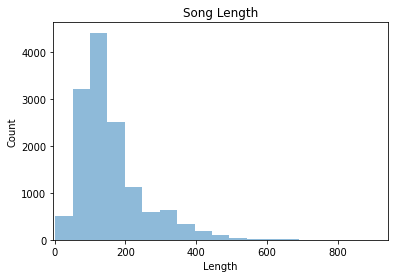

In [73]:
bins = np.linspace(math.ceil(min(df_train['Lyrics'].apply(len))), 
                   math.floor(max(df_train['Lyrics'].apply(len))),
                   20) # fixed number of bins

plt.xlim([min(df_train['Lyrics'].apply(len))-5, max(df_train['Lyrics'].apply(len))+5])

plt.hist(df_train['Lyrics'].apply(len), bins=bins, alpha=0.5)
plt.title('Song Length')
plt.xlabel('Length')
plt.ylabel('Count')

plt.show()

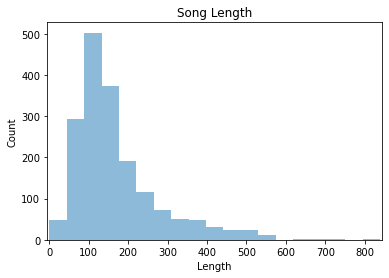

In [ ]:
bins = np.linspace(math.ceil(min(df_test['Lyrics'].apply(len))), 
                   math.floor(max(df_val['Lyrics'].apply(len))),
                   20) # fixed number of bins

plt.xlim([min(df_val['Lyrics'].apply(len))-5, max(df_val['Lyrics'].apply(len))+5])

plt.hist(df_val['Lyrics'].apply(len), bins=bins, alpha=0.5)
plt.title('Song Length')
plt.xlabel('Length')
plt.ylabel('Count')

plt.show()

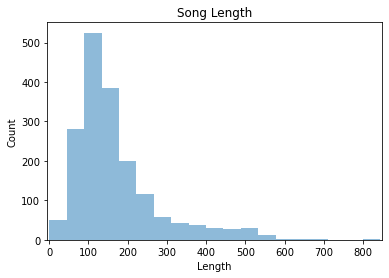

In [ ]:
bins = np.linspace(math.ceil(min(df_test['Lyrics'].apply(len))), 
                   math.floor(max(df_test['Lyrics'].apply(len))),
                   20) # fixed number of bins

plt.xlim([min(df_test['Lyrics'].apply(len))-5, max(df_test['Lyrics'].apply(len))+5])

plt.hist(df_test['Lyrics'].apply(len), bins=bins, alpha=0.5)
plt.title('Song Length')
plt.xlabel('Length')
plt.ylabel('Count')

plt.show()

i dont have a great sense for what embedding size will be good, so lets try a few different options

In [74]:
embedding_sizes = [200,300,400,500,600]
hidden_dim_sizes = [25,50,75,100,150,200]

In [76]:
best_dan_score, best_wan_score  = 0,0
best_dan_emb_size, best_wan_emb_size = None, None

for hd in hidden_dim_sizes:
  for embedding_size in embedding_sizes:
      
      train_tokens_prebuilt = text_to_index_post_cleaning(df_train['Lyrics'],vocab_dict,embedding_size)
      val_tokens_prebuilt = text_to_index_post_cleaning(df_val['Lyrics'],vocab_dict,embedding_size)
      
      dan_model_sorted = create_dan_model(embedding_matrix = embedding_matrix, output_layer_size = 7, max_sequence_length=embedding_size, hidden_dim=[hd,hd,hd])
      dan_sorted_history = dan_model_sorted.fit(np.array(train_tokens_prebuilt),
                          np.array(train_labels.map(mapping)),
                          validation_data=(np.array(val_tokens_prebuilt), np.array(val_labels.map(mapping))),
                          batch_size=8,
                          epochs=100,
                          shuffle=True,
                          use_multiprocessing=True,workers=multiprocessing.cpu_count() - 1,
                          callbacks = [es],
                          class_weight = class_weights)
      
      
      if max(dan_sorted_history.history['val_accuracy']) > best_dan_score:
              best_dan_score = max(dan_sorted_history.history['val_accuracy'])
              best_dan_emb_size = embedding_size
              
      wan_model_sorted = create_wan_model(embedding_matrix=embedding_matrix, output_layer_size = 7, max_sequence_length=embedding_size,
                                    num_attention=1, hidden_dim=[hd,hd,hd])
      wan_sorted_history = wan_model_sorted.fit(np.array(train_tokens_prebuilt),
                          np.array(train_labels.map(mapping)),
                          validation_data=(np.array(val_tokens_prebuilt), np.array(val_labels.map(mapping))),
                          batch_size=8,
                          epochs=100,
                          shuffle=True,
                          use_multiprocessing=True,workers=multiprocessing.cpu_count() - 1,
                          callbacks = [es],
                          class_weight = class_weights)
      
      
      if max(wan_sorted_history.history['val_accuracy']) > best_wan_score:
              best_wan_score = max(wan_sorted_history.history['val_accuracy'])
              best_wan_emb_size = embedding_size

print('best dan performance ', best_dan_score)
print('best dan embedding size ', best_dan_emb_size)
print('best wan performance ', best_wan_score)
print('best wan embedding size ', best_wan_emb_size)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200)]             0         
                                                                 
 embedding_layer (Embedding)  (None, 200, 300)         13194600  
                                                                 
 averaging (Lambda)          (None, 300)               0         
                                                                 
 hidden_1 (Dense)            (None, 25)                7525      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 hidden_2 (Dense)            (None, 25)                650       
                                                                 
 dropout_2 (Dropout)         (None, 25)                0   

# 3B Prebuilt Word Vectors, size experimentations

# 4 Custom Embeddings

Both of those models used prebuilt embeddings, what happens if we use custom ones?

In [57]:
train['Lyrics_String']=train['Lyrics'].apply(lambda x: " ".join(x))
val['Lyrics_String']=val['Lyrics'].apply(lambda x: " ".join(x))
test['Lyrics_String']=test['Lyrics'].apply(lambda x: " ".join(x))
vectorizer = CountVectorizer()

In [58]:
train['Lyrics_String']

0        d e e p   d i v e   s l i t h e r i n g   h e ...
1        a n d   h o w   d o e s   i t   f e e l   l i ...
2        w e l l ,   i   d o n ' t   w a n t   t o   b ...
3        i ' m   j u s t   t r y i n g   t o   m a k e ...
4        d e c e m b e r   3 1 s t ,   i   g r a b b e ...
                               ...                        
14831    y e a h   t h a n k   y o u ,   t h a n k   y ...
14832    w e   m u s t   p l a y   o u r   l i v e s   ...
14833    א ל   ת ח כ י   ל י   ע ו ד   ל י ד   ה ד ל ת ...
14834    l e t ' s   d a n c e   l i t t l e   s t r a ...
14835    w a t c h   t h a t   c i t y   b y   t h e   ...
Name: Lyrics_String, Length: 14821, dtype: object

In [60]:
type(train['Lyrics'].iloc[0])

str

In [61]:
#vectorizer.fit(train['Lyrics_String'])
vectorizer.fit(train['Lyrics'])

CountVectorizer()

In [62]:
len(vectorizer.get_feature_names())

83372

In [63]:
embedding_matrix_cust = np.random.random((len(vectorizer.get_feature_names()) + 1) * 300).reshape((len(vectorizer.get_feature_names()) + 1,300))

In [64]:
embedding_matrix_cust[-1] = 0

In [65]:
embedding_matrix_cust.shape

(83373, 300)

In [67]:
mapping_dict = {}
i = 0
for feature_name in vectorizer.get_feature_names():
    mapping_dict[feature_name] = i
    i += 1

In [68]:
def get_unique_words(dataset, mapping_dict, seq_size = 1000):
    mapped_lyrics = []
    for song in dataset:
        song_tokens = []
        try:
          for word in song.split():
            try:
                song_tokens.append(mapping_dict[word])
            except:
                song_tokens.append(len(mapping_dict))
        except:
          print(song)
          continue
        if len(song_tokens) > seq_size:
            song_tokens = song_tokens[:seq_size]
        elif len(song_tokens) < seq_size:
            while len(song_tokens) < seq_size:
                song_tokens.append(len(mapping_dict))
                    
        mapped_lyrics.append(song_tokens)
    return np.array(mapped_lyrics)
    

In [69]:
#mapped_lyrics_train = get_unique_words(df_train['Lyrics_String'], mapping_dict, seq_size = 1000)
#mapped_lyrics_val = get_unique_words(df_val['Lyrics_String'], mapping_dict, seq_size = 1000)
#mapped_lyrics_test = get_unique_words(df_test['Lyrics_String'], mapping_dict, seq_size = 1000)

mapped_lyrics_train = get_unique_words(train['Lyrics'], mapping_dict, seq_size = 1000)
mapped_lyrics_val = get_unique_words(val['Lyrics'], mapping_dict, seq_size = 1000)
mapped_lyrics_test = get_unique_words(test['Lyrics'], mapping_dict, seq_size = 1000)

In [70]:
#mapped_lyrics_train[0]
print(len(mapped_lyrics_train))
print(len(mapped_lyrics_val))
print(len(mapped_lyrics_test))

14821
1301
1296


In [71]:
mapping

{'Indie': 0,
 'Metal': 1,
 'Pop': 2,
 'Rock': 3,
 'Alternative': 4,
 'Hip Hop': 5,
 'Blues': 6}

In [72]:
train_labels.value_counts()

Rock           4763
Indie          2338
Pop            2106
Metal          1791
Hip Hop        1491
Alternative    1435
Blues           897
Name: Major Genre, dtype: int64

In [73]:
weights = 4763/train_labels.value_counts()
class_weights = {}
for num in range(len(weights)):
    class_weights[mapping[weights.index[num]]] = weights.iloc[num]

In [74]:
class_weights

{3: 1.0,
 0: 2.0372112917023095,
 2: 2.261633428300095,
 1: 2.6594081518704633,
 5: 3.194500335345406,
 4: 3.3191637630662023,
 6: 5.309921962095875}

In [75]:
dan_model_sorted = create_dan_model(embedding_matrix = embedding_matrix_cust, output_layer_size = 7)
dan_sorted_history = dan_model_sorted.fit(np.array(mapped_lyrics_train),
                        np.array(train_labels.map(mapping)),
                        validation_data=(np.array(mapped_lyrics_test), np.array(test_labels.map(mapping))),
                        batch_size=8,
                        epochs=30,
                        shuffle=True,
                        use_multiprocessing=True,workers=multiprocessing.cpu_count() - 2,
                        callbacks = [es],
                        class_weight = class_weights                  
                        )

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1000)]            0         
                                                                 
 embedding_layer (Embedding)  (None, 1000, 300)        25011900  
                                                                 
 averaging (Lambda)          (None, 300)               0         
                                                                 
 hidden_1 (Dense)            (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 hidden_2 (Dense)            (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0   

In [76]:
wan_model_sorted = create_wan_model(embedding_matrix=embedding_matrix_cust, output_layer_size = 7,
                                   num_attention=1, hidden_dim = [150,150,150])
wan_sorted_history = wan_model_sorted.fit(np.array(mapped_lyrics_train),
                        np.array(train_labels.map(mapping)),
                        validation_data=(np.array(mapped_lyrics_test), np.array(test_labels.map(mapping))),
                        batch_size=8,
                        epochs=100,
                        shuffle=True,
                        use_multiprocessing=True,workers=multiprocessing.cpu_count() - 1,
                        #callbacks = [es],
                        class_weight = class_weights)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1000)]       0           []                               
                                                                                                  
 embedding_layer (Embedding)    (None, 1000, 300)    25011900    ['input[0][0]']                  
                                                                                                  
 attention_query1 (Dense)       (None, 1000, 1)      300         ['embedding_layer[0][0]']        
                                                                                                  
 reshape_3 (Reshape)            (None, 1, 1000)      0           ['attention_query1[0][0]']       
                                                                                            

KeyboardInterrupt: 

best result .29

lets experiment with embedding size and see if we find anything interesting

In [120]:
best_dan_score, best_wan_score  = 0,0
best_dan_emb_size, best_wan_emb_size = None, None
embedding_sizes_cust = [100,200,300,400,500,600,700,800,900]

for embedding_size in embedding_sizes_cust:
    
    mapped_lyrics_train = get_unique_words(df_train['Lyrics_String'], mapping_dict, seq_size = embedding_size)
    mapped_lyrics_val = get_unique_words(df_val['Lyrics_String'], mapping_dict, seq_size = embedding_size)
    
    dan_model_sorted = create_dan_model(embedding_matrix = embedding_matrix_cust, output_layer_size = 7, max_sequence_length=embedding_size, hidden_dim=[75,75,75])
    dan_sorted_history = dan_model_sorted.fit(np.array(mapped_lyrics_train),
                        np.array(train_labels.map(mapping)),
                        validation_data=(np.array(mapped_lyrics_val), np.array(val_labels.map(mapping))),
                        batch_size=8,
                        epochs=100,
                        shuffle=True,
                        use_multiprocessing=True,workers=multiprocessing.cpu_count() - 2,
                        callbacks = [es],
                        class_weight = class_weights)
    
    
    if max(dan_sorted_history.history['val_accuracy']) > best_dan_score:
            best_dan_score = max(dan_sorted_history.history['val_accuracy'])
            best_dan_emb_size = embedding_size
            
    wan_model_sorted = create_wan_model(embedding_matrix=embedding_matrix_cust, output_layer_size = 7, max_sequence_length=embedding_size, hidden_dim=[150,150,150],
                                   num_attention=1)
    wan_sorted_history = wan_model_sorted.fit(np.array(mapped_lyrics_train),
                        np.array(train_labels.map(mapping)),
                        validation_data=(np.array(mapped_lyrics_val), np.array(val_labels.map(mapping))),
                        batch_size=8,
                        epochs=100,
                        shuffle=True,
                        use_multiprocessing=True,workers=multiprocessing.cpu_count() - 2,
                        callbacks = [es],
                        class_weight = class_weights)
    
    
    if max(wan_sorted_history.history['val_accuracy']) > best_wan_score:
            best_wan_score = max(wan_sorted_history.history['val_accuracy'])
            best_wan_emb_size = embedding_size

print('best dan performance ', best_dan_score)
print('best dan embedding size ', best_dan_emb_size)
print('best wan performance ', best_wan_score)
print('best wan embedding size ', best_wan_emb_size)

Model: "model_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 100)]             0         
                                                                 
 embedding_layer (Embedding)  (None, 100, 300)         30549300  
                                                                 
 averaging (Lambda)          (None, 300)               0         
                                                                 
 hidden_1 (Dense)            (None, 75)                22575     
                                                                 
 dropout_1 (Dropout)         (None, 75)                0         
                                                                 
 hidden_2 (Dense)            (None, 75)                5700      
                                                                 
 dropout_2 (Dropout)         (None, 75)                0  

currently:

best dan performance  0.2635399103164673
best dan embedding size  600
best wan performance  0.303740918636322
best wan embedding size  700

700 probably best size

# 5 Audio Feature DL

lets look at the audio features we have too

In [77]:
# let's create a df that is all of the normalized audio features we want to use
#df_train_audio_normalized = df_train[['danceability', 'energy', 'loudness', 'acousticness', 'speechiness', 'instrumentalness', 'valence', 'tempo','duration_ms']].copy()
#df_train_audio_normalized = (df_train_audio_normalized-df_train_audio_normalized.mean())/df_train_audio_normalized.std()

#df_val_audio_normalized = df_val[['danceability', 'energy', 'loudness', 'acousticness', 'speechiness', 'instrumentalness', 'valence', 'tempo','duration_ms']].copy()
#df_val_audio_normalized = (df_val_audio_normalized-df_val_audio_normalized.mean())/df_val_audio_normalized.std()

#df_test_audio_normalized = df_test[['danceability', 'energy', 'loudness', 'acousticness', 'speechiness', 'instrumentalness', 'valence', 'tempo','duration_ms']].copy()
#df_test_audio_normalized = (df_test_audio_normalized-df_test_audio_normalized.mean())/df_test_audio_normalized.std()

In [77]:
# let's create a df that is all of the normalized audio features we want to use
df_train_audio_normalized = train[['danceability', 'energy', 'loudness', 'acousticness', 'speechiness', 'instrumentalness', 'valence', 'tempo','duration_ms']].copy()
df_train_audio_normalized = (df_train_audio_normalized-df_train_audio_normalized.mean())/df_train_audio_normalized.std()

df_val_audio_normalized = val[['danceability', 'energy', 'loudness', 'acousticness', 'speechiness', 'instrumentalness', 'valence', 'tempo','duration_ms']].copy()
df_val_audio_normalized = (df_val_audio_normalized-df_val_audio_normalized.mean())/df_val_audio_normalized.std()

df_test_audio_normalized = test[['danceability', 'energy', 'loudness', 'acousticness', 'speechiness', 'instrumentalness', 'valence', 'tempo','duration_ms']].copy()
df_test_audio_normalized = (df_test_audio_normalized-df_test_audio_normalized.mean())/df_test_audio_normalized.std()

In [78]:
#len(df_train_audio_normalized)
#len(df_val_audio_normalized)
#len(df_test_audio_normalized)

In [78]:
# reminder, what does our data look like?
df_train_audio_normalized

,danceability,energy,loudness,acousticness,speechiness,instrumentalness,valence,tempo,duration_ms
0,1.073187,0.955241,0.570070,-0.179892,-0.548726,-0.255777,1.646805,0.381884,-0.493200
1,-1.781914,0.793719,1.071145,-0.647344,-0.092345,-0.419146,-0.409744,0.076545,0.092574
2,-1.066636,1.151025,1.179788,-0.683648,0.084061,-0.418755,-0.327827,1.473613,0.161564
3,0.652435,-1.638895,-0.726406,-0.031913,0.060161,-0.051744,-1.220292,0.052641,1.579205
4,0.922919,-0.552295,-0.020225,1.663839,1.379225,-0.419170,-0.478727,-1.340843,-0.647679
...,...,...,...,...,...,...,...,...,...
14831,0.832758,0.407046,0.905876,-0.442654,0.912602,-0.419186,1.107877,-0.596040,-0.323360
14832,-0.826206,-0.317354,-1.223531,-0.556237,-0.486130,-0.363956,-0.263156,-0.007304,0.487865
14833,0.682489,-1.736787,-0.436691,3.035640,-0.531654,-0.419186,0.577572,0.386009,-1.101218
14834,-0.122950,1.033554,0.384389,-0.679983,-0.187946,0.758457,1.181171,0.332792,-0.323903


In [79]:
# audio features should help too: lets see what results we get from
# a standard feed-forward network
# note: audio features have been normalized
hidden_sizes = [100]
best_score, best_hidden_size = 0,0

for hs in hidden_sizes:
  model = keras.Sequential([
      keras.layers.Dense(hs,activation='relu'),
      keras.layers.Dense(hs,activation='relu'),
      keras.layers.Dense(7,activation='softmax')
  ])

  #Compile the model, specifying loss function, optimizer, and performance metric
  model.compile(loss = keras.losses.SparseCategoricalCrossentropy(),
              optimizer = keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'],
              )

  model_history = model.fit(x = np.array(df_train_audio_normalized),y = train_labels.map(mapping),batch_size=8,epochs=30,
          validation_data = (np.array(df_test_audio_normalized), test_labels.map(mapping)),
          use_multiprocessing=True,workers=multiprocessing.cpu_count() - 1, class_weight = class_weights)
  
  if max(model_history.history['val_accuracy']) > best_score:
            best_score = max(model_history.history['val_accuracy'])
            best_hidden_size = hs

Epoch 1/30
1853/1853 [==============================] - 5s 2ms/step - loss: 3.4414 - accuracy: 0.3662 - val_loss: 1.5544 - val_accuracy: 0.3873
Epoch 2/30
1853/1853 [==============================] - 4s 2ms/step - loss: 3.3268 - accuracy: 0.3848 - val_loss: 1.5761 - val_accuracy: 0.3889
Epoch 3/30
1853/1853 [==============================] - 4s 2ms/step - loss: 3.2871 - accuracy: 0.3940 - val_loss: 1.5315 - val_accuracy: 0.4074
Epoch 4/30
1853/1853 [==============================] - 4s 2ms/step - loss: 3.2493 - accuracy: 0.3967 - val_loss: 1.5937 - val_accuracy: 0.3812
Epoch 5/30
1853/1853 [==============================] - 4s 2ms/step - loss: 3.2066 - accuracy: 0.3994 - val_loss: 1.5464 - val_accuracy: 0.3765
Epoch 6/30
1853/1853 [==============================] - 4s 2ms/step - loss: 3.1950 - accuracy: 0.4006 - val_loss: 1.5184 - val_accuracy: 0.4120
Epoch 7/30
1853/1853 [==============================] - 5s 3ms/step - loss: 3.2039 - accuracy: 0.3994 - val_loss: 1.5346 - val_accuracy:

In [81]:
print(best_score)
print(best_hidden_size)

0.4379521310329437
100


best hidden size 0.42211055755615234
best score 100

best score = 
best h size = 

```
`# This is formatted as code`
```



In [80]:
#predictions = model.predict(np.array(df_test_audio_normalized))
#predictions = model.predict([np.array(test_term_df), np.array(df_test_audio_normalized)])
predictions = model.predict(np.array(df_test_audio_normalized))

41/41 [==============================] - 0s 2ms/step


In [81]:
predictions_ = [x.argmax() for x in predictions]

In [82]:
conf = sklearn.metrics.confusion_matrix(test_labels.map(mapping), predictions_)
conf = pd.DataFrame(conf, index = mapping.keys(), columns = mapping.keys())
conf

,Indie,Metal,Pop,Rock,Alternative,Hip Hop,Blues
Indie,21,23,30,62,49,6,32
Metal,1,100,1,27,8,0,0
Pop,4,3,99,33,13,25,22
Rock,5,104,27,152,38,18,58
Alternative,4,21,18,47,18,8,21
Hip Hop,3,0,15,3,3,95,5
Blues,2,0,13,12,4,0,43


write up some precision/recall stuff on the final conf

# 6. Lyrics + Audio DL

In [ ]:
def create_multimodal_genre_FFN(max_sequence_length = 1000, retrain_embeddings = True, learning_rate = 0.01):
    audio_inputs = keras.layers.Input(shape = (8,), dtype = 'float32', name = 'audio_input')
    lyric_inputs = keras.layers.Input(shape = (1000,), dtype='int64',name='lyric_input')
                                    
    ffn_embedding_layer = Embedding(embedding_matrix.shape[0],
                                  embedding_matrix.shape[1],
                                  weights = [embedding_matrix],
                                  input_length=max_sequence_length,
                                  trainable=retrain_embeddings,
                                   name = 'embedding_layer')
    
    #Input Layer, sequence of max_sequence_length tokens
    #ffn_input_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int64',name='input')
    #Inputs go into embedding layer, form max_sequence_length x embedding dim matrix
    ffn_embeddings = ffn_embedding_layer(lyric_inputs)
    ffn_avg_input_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name='averaging')(ffn_embeddings)
    concat_ffn = tf.keras.layers.Concatenate()([ffn_avg_input_embeddings,audio_inputs])
    hidden = keras.layers.Dense(100,activation='relu')(concat_ffn)
    classification = keras.layers.Dense(7,activation='softmax')(hidden)
    
    ffn_model = tf.keras.models.Model(inputs=[audio_inputs,lyric_inputs], outputs=[classification])
    ffn_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                beta_1=0.9,
                                                beta_2=0.999,
                                                epsilon=1e-07,
                                                amsgrad=False,
                                                name='Adam'),
                 metrics='accuracy',
                     run_eagerly = True)
    
    print(ffn_model.summary())

    return ffn_model
  
    

In [83]:
# 200 was our best prebuilt embedding size so lets try it here

#train_tokens_prebuilt_new = text_to_index_post_cleaning(df_train['Lyrics'],vocab_dict,200)
#val_tokens_prebuilt_new = text_to_index_post_cleaning(df_val['Lyrics'],vocab_dict,200)
#test_tokens_prebuilt_new = text_to_index_post_cleaning(df_test['Lyrics'],vocab_dict,200)

train_tokens_prebuilt_new = text_to_index_post_cleaning(train['Lyrics'],vocab_dict,200)
val_tokens_prebuilt_new = text_to_index_post_cleaning(val['Lyrics'],vocab_dict,200)
test_tokens_prebuilt_new = text_to_index_post_cleaning(test['Lyrics'],vocab_dict,200)

In [84]:
# define two sets of inputs
inputA = Input(shape=(200,))
inputB = Input(shape=(9,))
# the first branch operates on the first input
x = Dense(8, activation="relu")(inputA)
x = Dense(4, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
y = Dense(64, activation="relu")(inputB)
y = Dense(32, activation="relu")(y)
y = Dense(4, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a classification prediction on the
# combined outputs
z = Dense(2, activation="relu")(combined)
z = Dense(7, activation="softmax")(z)
#z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

In [85]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=.001,
                                                beta_1=0.9,
                                                beta_2=0.999,
                                                epsilon=1e-07,
                                                amsgrad=False,
                                                name='Adam'),
             metrics='accuracy',
             )

In [86]:
model.fit(x=[np.array(train_tokens_prebuilt_new), np.array(df_train_audio_normalized)], y=train_labels.map(mapping), validation_data=([np.array(test_tokens_prebuilt_new), np.array(df_test_audio_normalized)], test_labels.map(mapping)), epochs=100, batch_size=8,
             class_weight = class_weights, callbacks = [es])

Epoch 1/100
1853/1853 [==============================] - 5s 2ms/step - loss: 6.0094 - accuracy: 0.1434 - val_loss: 1.9388 - val_accuracy: 0.1080
Epoch 2/100
1853/1853 [==============================] - 4s 2ms/step - loss: 4.3253 - accuracy: 0.1161 - val_loss: 1.9344 - val_accuracy: 0.1103
Epoch 3/100
1853/1853 [==============================] - 6s 3ms/step - loss: 4.3152 - accuracy: 0.1179 - val_loss: 1.9333 - val_accuracy: 0.1165
Epoch 4/100
1853/1853 [==============================] - 6s 3ms/step - loss: 4.3055 - accuracy: 0.1202 - val_loss: 1.9280 - val_accuracy: 0.1258
Epoch 5/100
1853/1853 [==============================] - 5s 3ms/step - loss: 4.2979 - accuracy: 0.1339 - val_loss: 1.9239 - val_accuracy: 0.1204
Epoch 6/100
1853/1853 [==============================] - 6s 3ms/step - loss: 4.3226 - accuracy: 0.1251 - val_loss: 1.9413 - val_accuracy: 0.0957
Epoch 7/100
1853/1853 [==============================] - 6s 3ms/step - loss: 4.3789 - accuracy: 0.1140 - val_loss: 1.9453 - val_ac

.3634 with emb size 200 val

In [87]:
# 600 was best performing emb size in the basic wan

#train_tokens_prebuilt_new = text_to_index_post_cleaning(df_train['Lyrics'],vocab_dict,600)
#val_tokens_prebuilt_new = text_to_index_post_cleaning(df_val['Lyrics'],vocab_dict,600)
#test_tokens_prebuilt_new = text_to_index_post_cleaning(df_test['Lyrics'],vocab_dict,600)

NameError: name 'df_train' is not defined

In [88]:
train_tokens_prebuilt_new = text_to_index_post_cleaning(train['Lyrics'],vocab_dict,600)
val_tokens_prebuilt_new = text_to_index_post_cleaning(val['Lyrics'],vocab_dict,600)
test_tokens_prebuilt_new = text_to_index_post_cleaning(test['Lyrics'],vocab_dict,600)

In [89]:
# run this

# -------------------------------Model that accepts input and creates embedding matrix-------------------------------
#input_layer = tf.keras.layers.Input(shape=(1000,))
lyric_input = tf.keras.layers.Input(shape=(600,))
audio_input = tf.keras.layers.Input(shape=(9,))
#Specify Embedding Layer, including shape, intialize with weights, expected input length, and whether it is trainable
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights = [embedding_matrix],
                            input_length=1000,
                            trainable=True,
                            name = 'embedding_layer')

embeddings = embedding_layer(lyric_input)
embedding_model = tf.keras.Model(inputs = [lyric_input],outputs=[embeddings])


# -----------------------------------------------------AUDIO FFN MODEL-----------------------------------------------------

# AUDIO
#audio_layer = Dense(300, activation="relu")(audio_input)
# add more layers?
audio_model = tf.keras.Model(inputs = [audio_input],outputs=[audio_input])

# -----------------------------------------------------WAN Model-----------------------------------------------------
# LYRICS
#Apply Query Vector to attention based representations, returning a num_attention x 1 tensor
query = tf.keras.layers.Dense(1,activation='linear',use_bias=False,name='attention_query')(embedding_model.output)
#reshape to 1 x num_attention
reshaped_query = tf.keras.layers.Reshape((1,600))(query)
#Softmax over query * key (words) to obtain weights
weights = tf.keras.layers.Lambda(lambda x:tf.keras.activations.softmax(x),
                                    name='attention_weights')(reshaped_query)
#weight attention embeddings according to weights, learning how to balance attention based vector representations 
#from prior layer
wan_embedding = tf.keras.layers.Flatten()(tf.keras.layers.Dot((1,2))((embedding_model.output,weights)))
wan_embedding = tf.keras.Model(inputs=[embedding_model.input],outputs=[wan_embedding])

# WAN Model that uses an attention layer with a single node to learn how to combine WAN/DAN embeddings into single representation
dual_embedding = tf.keras.layers.concatenate([audio_model.output,wan_embedding.output])
#dual_embedding = tf.keras.layers.Reshape((2,embedding_matrix.shape[1]))(dual_embedding)
#query = tf.keras.layers.Dense(1,activation='linear',use_bias=False)(dual_embedding)
#reshaped_query = tf.keras.layers.Reshape((1,2))(query)
#weights = tf.keras.layers.Lambda(lambda x:tf.keras.activations.softmax(x))(reshaped_query)
#embedding = tf.keras.layers.Flatten()(tf.keras.layers.Dot((1,2))((dual_embedding,weights)))
hidden = tf.keras.layers.Dense(100,activation='relu')(dual_embedding)
hidden = tf.keras.layers.Dense(100,activation='relu')(hidden)
output = tf.keras.layers.Dense(7,activation='softmax')(hidden)
final_model = tf.keras.Model(inputs=[audio_model.input, embedding_model.input],outputs=[output])

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                            metrics='accuracy') 

In [90]:
final_model.fit(x=[np.array(df_train_audio_normalized), np.array(train_tokens_prebuilt_new)], y=train_labels.map(mapping), validation_data=([np.array(df_test_audio_normalized), np.array(test_tokens_prebuilt_new)], test_labels.map(mapping)), epochs=30, batch_size=8,
             class_weight = class_weights, callbacks = [es])

Epoch 1/30
1853/1853 [==============================] - 326s 172ms/step - loss: 3.2117 - accuracy: 0.3939 - val_loss: 1.4412 - val_accuracy: 0.4120
Epoch 2/30
1853/1853 [==============================] - 351s 189ms/step - loss: 3.0254 - accuracy: 0.4183 - val_loss: 1.4330 - val_accuracy: 0.3974
Epoch 3/30
1853/1853 [==============================] - 291s 157ms/step - loss: 2.9538 - accuracy: 0.4298 - val_loss: 1.4250 - val_accuracy: 0.4028
Epoch 4/30
1853/1853 [==============================] - 325s 175ms/step - loss: 2.9018 - accuracy: 0.4334 - val_loss: 1.3837 - val_accuracy: 0.4529
Epoch 5/30
1853/1853 [==============================] - 336s 181ms/step - loss: 2.8575 - accuracy: 0.4424 - val_loss: 1.4286 - val_accuracy: 0.4244
Epoch 6/30
1853/1853 [==============================] - 311s 168ms/step - loss: 2.8046 - accuracy: 0.4519 - val_loss: 1.4349 - val_accuracy: 0.4074
Epoch 7/30
1853/1853 [==============================] - 291s 157ms/step - loss: 2.7653 - accuracy: 0.4552 - val_

In [70]:
#def run_big_combined_model(num_h = 1, hidden_sizes = [100]):
hidden_sizes = [100,200,300,500]
num_hs = [2,3,1]

best_score, best_hidden_size = 0,0
for num_h in num_hs:   
    for hidden_size in hidden_sizes:
        print(num_h, hidden_size)
        if num_h == 2 and hidden_size == 100:
            continue
        else:


            # -------------------------------Model that accepts input and creates embedding matrix-------------------------------
            #input_layer = tf.keras.layers.Input(shape=(1000,))
            lyric_input = tf.keras.layers.Input(shape=(600,))
            audio_input = tf.keras.layers.Input(shape=(9,))
            #Specify Embedding Layer, including shape, intialize with weights, expected input length, and whether it is trainable
            embedding_layer = Embedding(embedding_matrix.shape[0],
                                        embedding_matrix.shape[1],
                                        weights = [embedding_matrix],
                                        input_length=1000,
                                        trainable=True,
                                        name = 'embedding_layer')

            embeddings = embedding_layer(lyric_input)
            embedding_model = tf.keras.Model(inputs = [lyric_input],outputs=[embeddings])


            # -----------------------------------------------------AUDIO FFN MODEL-----------------------------------------------------

            # AUDIO
            #audio_layer = Dense(300, activation="relu")(audio_input)
            # add more layers?
            audio_model = tf.keras.Model(inputs = [audio_input],outputs=[audio_input])

            # -----------------------------------------------------WAN Model-----------------------------------------------------
            # LYRICS
            #Apply Query Vector to attention based representations, returning a num_attention x 1 tensor
            query = tf.keras.layers.Dense(1,activation='linear',use_bias=False,name='attention_query')(embedding_model.output)
            #reshape to 1 x num_attention
            reshaped_query = tf.keras.layers.Reshape((1,600))(query)
            #Softmax over query * key (words) to obtain weights
            weights = tf.keras.layers.Lambda(lambda x:tf.keras.activations.softmax(x),
                                                name='attention_weights')(reshaped_query)
            #weight attention embeddings according to weights, learning how to balance attention based vector representations 
            #from prior layer
            wan_embedding = tf.keras.layers.Flatten()(tf.keras.layers.Dot((1,2))((embedding_model.output,weights)))
            wan_embedding = tf.keras.Model(inputs=[embedding_model.input],outputs=[wan_embedding])

            # WAN Model that uses an attention layer with a single node to learn how to combine WAN/DAN embeddings into single representation
            dual_embedding = tf.keras.layers.concatenate([audio_model.output,wan_embedding.output])
            #dual_embedding = tf.keras.layers.Reshape((2,embedding_matrix.shape[1]))(dual_embedding)
            #query = tf.keras.layers.Dense(1,activation='linear',use_bias=False)(dual_embedding)
            #reshaped_query = tf.keras.layers.Reshape((1,2))(query)
            #weights = tf.keras.layers.Lambda(lambda x:tf.keras.activations.softmax(x))(reshaped_query)
            #embedding = tf.keras.layers.Flatten()(tf.keras.layers.Dot((1,2))((dual_embedding,weights)))
            hidden = tf.keras.layers.Dense(hidden_size,activation='relu')(dual_embedding)
            if num_h > 1:
                for num in range(num_h):
                    hidden = tf.keras.layers.Dense(hidden_size,activation='relu')(hidden)
            output = tf.keras.layers.Dense(7,activation='softmax')(hidden)
            final_model = tf.keras.Model(inputs=[audio_model.input, embedding_model.input],outputs=[output])

            final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                        loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                                        metrics='accuracy')

            final_model_history = final_model.fit(x=[np.array(df_train_audio_normalized), np.array(train_tokens_prebuilt_new)], y=train_labels.map(mapping), validation_data=([np.array(df_test_audio_normalized), np.array(test_tokens_prebuilt_new)], test_labels.map(mapping)), epochs=10, batch_size=8,
                     class_weight = class_weights, callbacks = [es]) 

            if max(final_model_history.history['val_accuracy']) > best_score:
                    best_score = max(final_model_history.history['val_accuracy'])
                    best_hidden_size = hidden_size

    print(best_score, best_hidden_size)
            

2 100
2 200
Epoch 1/10
1719/1719 [==============================] - 310s 180ms/step - loss: 3.1187 - accuracy: 0.3891 - val_loss: 1.4125 - val_accuracy: 0.4324
Epoch 2/10
1719/1719 [==============================] - 285s 166ms/step - loss: 2.5840 - accuracy: 0.4650 - val_loss: 1.3665 - val_accuracy: 0.4174
Epoch 3/10
1719/1719 [==============================] - 265s 154ms/step - loss: 2.1200 - accuracy: 0.5378 - val_loss: 1.4928 - val_accuracy: 0.3973
Epoch 4/10
1719/1719 [==============================] - 263s 153ms/step - loss: 1.7342 - accuracy: 0.6041 - val_loss: 1.5417 - val_accuracy: 0.4101
Epoch 4: early stopping
2 300
Epoch 1/10
1719/1719 [==============================] - 272s 158ms/step - loss: 3.1208 - accuracy: 0.3924 - val_loss: 1.4565 - val_accuracy: 0.4279
Epoch 2/10
1719/1719 [==============================] - 274s 159ms/step - loss: 2.6081 - accuracy: 0.4561 - val_loss: 1.4051 - val_accuracy: 0.3973
Epoch 3/10
1719/1719 [==============================] - 262s 152ms/ste

0.4691151976585388 300, 1

In [ ]:
tf.executing_eagerly()

True

In [ ]:
final_model.fit(x=[np.array(train_tokens_prebuilt_new), np.array(df_train_audio_normalized)], y=train_labels.map(mapping), validation_data=([np.array(test_tokens_prebuilt_new), np.array(df_test_audio_normalized)], test_labels.map(mapping)), epochs=10, batch_size=8,
             class_weight = class_weights)

Epoch 1/10


ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_48" is incompatible with the layer: expected shape=(None, 9), found shape=(None, 1000)


In [ ]:
# -------------------------------Model that accepts input and creates embedding matrix-------------------------------
#input_layer = tf.keras.layers.Input(shape=(1000,))
lyric_input = tf.keras.layers.Input(shape=(1000,))
audio_input = tf.keras.layers.Input(shape=(9,))
#Specify Embedding Layer, including shape, intialize with weights, expected input length, and whether it is trainable
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            weights = [embedding_matrix],
                            input_length=1000,
                            trainable=True,
                            name = 'embedding_layer')

audio_layer = Dense(100, activation="relu")(audio_input)

embeddings = embedding_layer(lyric_input)
embedding_model = tf.keras.Model(inputs = [lyric_input],outputs=[embeddings])

audio_model = tf.keras.Model(inputs = [audio_input],outputs=[audio_layer])

# -----------------------------------------------------DAN MODEL-----------------------------------------------------
# AUDIO
avg_embedding_audio = tf.keras.layers.Lambda(lambda x:K.mean(x,axis=1))(audio_model.output)
avg_embedding_audio = tf.keras.layers.Reshape((1,embedding_matrix.shape[1]))(avg_embedding_audio)
avg_embedding_audio = tf.keras.Model(inputs = [audio_model.input], outputs = [avg_embedding_audio])


# -----------------------------------------------------WAN Model-----------------------------------------------------
# LYRICS
#Apply Query Vector to attention based representations, returning a num_attention x 1 tensor
query = tf.keras.layers.Dense(1,activation='linear',use_bias=False,name='attention_query')(embedding_model.output)
#reshape to 1 x num_attention
reshaped_query = tf.keras.layers.Reshape((1,1000))(query)
#Softmax over query * key (words) to obtain weights
weights = tf.keras.layers.Lambda(lambda x:tf.keras.activations.softmax(x),
                                    name='attention_weights')(reshaped_query)
#weight attention embeddings according to weights, learning how to balance attention based vector representations 
#from prior layer
wan_embedding = tf.keras.layers.Flatten()(tf.keras.layers.Dot((1,2))((embedding_model.output,weights)))
wan_embedding = tf.keras.Model(inputs=[embedding_model.input],outputs=[wan_embedding])

# WAN Model that uses an attention layer with a single node to learn how to combine WAN/DAN embeddings into single representation
dual_embedding = tf.keras.layers.concatenate([audio_reshaped.output,wan_embedding.output])
dual_embedding = tf.keras.layers.Reshape((2,embedding_matrix_custom.shape[1]))(dual_embedding)
query = tf.keras.layers.Dense(1,activation='linear',use_bias=False)(dual_embedding)
reshaped_query = tf.keras.layers.Reshape((1,2))(query)
weights = tf.keras.layers.Lambda(lambda x:tf.keras.activations.softmax(x))(reshaped_query)
embedding = tf.keras.layers.Flatten()(tf.keras.layers.Dot((1,2))((dual_embedding,weights)))
hidden = tf.keras.layers.Dense(100,activation='relu')(embedding)
output = tf.keras.layers.Dense(11,activation='softmax')(hidden)
final_model = tf.keras.Model(inputs=[embedding_model.input],outputs=[output])

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                            loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                            metrics='accuracy') 

ValueError: Exception encountered when calling layer "reshape_4" (type Reshape).

total size of new array must be unchanged, input_shape = [], output_shape = [1, 300]

Call arguments received by layer "reshape_4" (type Reshape):
  • inputs=tf.Tensor(shape=(None,), dtype=float32)

In [ ]:
print(embedding_matrix.shape[0], embedding_matrix.shape[1])

43982 300


# 6a Joint Model with Custom Embeddings

In [84]:
mapped_lyrics_train = get_unique_words(df_train['Lyrics_String'], mapping_dict, seq_size = embedding_size)
mapped_lyrics_val = get_unique_words(df_val['Lyrics_String'], mapping_dict, seq_size = embedding_size)

In [86]:
embedding_size

500

In [99]:
print(embedding_matrix.shape[0])
print(embedding_matrix.shape[1])

print(embedding_matrix_cust.shape[0])
print(embedding_matrix_cust.shape[1])

print(embedding_matrix_custom)

#print((mapped_lyrics_train[0]))

43982
300
101831
300
None


In [107]:
embedding_sizes_cust = [600]
hidden_size = 300
num_h = 1

# need to run with 1,300 too or whatever max ends up being

best_score, best_embedding_size = 0,0
for embedding_size in embedding_sizes_cust:
    
    mapped_lyrics_train = get_unique_words(train['Lyrics'], mapping_dict, seq_size = embedding_size)
    mapped_lyrics_val = get_unique_words(test['Lyrics'], mapping_dict, seq_size = embedding_size)

    # -------------------------------Model that accepts input and creates embedding matrix-------------------------------
    #input_layer = tf.keras.layers.Input(shape=(1000,))
    lyric_input = tf.keras.layers.Input(shape=(embedding_size,))
    audio_input = tf.keras.layers.Input(shape=(9,))
    #Specify Embedding Layer, including shape, intialize with weights, expected input length, and whether it is trainable
    #embedding_layer = Embedding(embedding_matrix.shape[0],
     #                           embedding_matrix.shape[1],
      #                          weights = [embedding_matrix],
       #                         input_length=1000,
        #                        trainable=True,
         #                       name = 'embedding_layer')
    
    embedding_layer = Embedding(embedding_matrix_cust.shape[0],
                                embedding_matrix_cust.shape[1],
                                weights = [embedding_matrix_cust],
                                input_length=1000,
                                trainable=True,
                                name = 'embedding_layer')
    
    

    embeddings = embedding_layer(lyric_input)
    embedding_model = tf.keras.Model(inputs = [lyric_input],outputs=[embeddings])


    # -----------------------------------------------------AUDIO FFN MODEL-----------------------------------------------------

    # AUDIO
    #audio_layer = Dense(300, activation="relu")(audio_input)
    # add more layers?
    audio_model = tf.keras.Model(inputs = [audio_input],outputs=[audio_input])

    # -----------------------------------------------------WAN Model-----------------------------------------------------
    # LYRICS
    #Apply Query Vector to attention based representations, returning a num_attention x 1 tensor
    query = tf.keras.layers.Dense(1,activation='linear',use_bias=False,name='attention_query')(embedding_model.output)
    #reshape to 1 x num_attention
    reshaped_query = tf.keras.layers.Reshape((1,embedding_size))(query)
    #Softmax over query * key (words) to obtain weights
    weights = tf.keras.layers.Lambda(lambda x:tf.keras.activations.softmax(x),
                                        name='attention_weights')(reshaped_query)
    #weight attention embeddings according to weights, learning how to balance attention based vector representations 
    #from prior layer
    wan_embedding = tf.keras.layers.Flatten()(tf.keras.layers.Dot((1,2))((embedding_model.output,weights)))
    wan_embedding = tf.keras.Model(inputs=[embedding_model.input],outputs=[wan_embedding])

    # WAN Model that uses an attention layer with a single node to learn how to combine WAN/DAN embeddings into single representation
    dual_embedding = tf.keras.layers.concatenate([audio_model.output,wan_embedding.output])
    #dual_embedding = tf.keras.layers.Reshape((2,embedding_matrix.shape[1]))(dual_embedding)
    #query = tf.keras.layers.Dense(1,activation='linear',use_bias=False)(dual_embedding)
    #reshaped_query = tf.keras.layers.Reshape((1,2))(query)
    #weights = tf.keras.layers.Lambda(lambda x:tf.keras.activations.softmax(x))(reshaped_query)
    #embedding = tf.keras.layers.Flatten()(tf.keras.layers.Dot((1,2))((dual_embedding,weights)))
    hidden = tf.keras.layers.Dense(hidden_size,activation='relu')(dual_embedding)
    if num_h > 1:
        for num in range(num_h):
            hidden = tf.keras.layers.Dense(hidden_size,activation='relu')(hidden)
    output = tf.keras.layers.Dense(7,activation='softmax')(hidden)
    final_model = tf.keras.Model(inputs=[audio_model.input, embedding_model.input],outputs=[output])

    final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                                metrics='accuracy')

    final_model_history = final_model.fit(x=[np.array(df_train_audio_normalized), np.array(mapped_lyrics_train)], y=train_labels.map(mapping), validation_data=([np.array(df_test_audio_normalized), np.array(mapped_lyrics_test)], test_labels.map(mapping)), epochs=30, batch_size=8,
             class_weight = class_weights, callbacks = [es]) 

    if max(final_model_history.history['val_accuracy']) > best_score:
            best_score = max(final_model_history.history['val_accuracy'])
            best_embedding_size = embedding_size

print(best_score, best_embedding_size)
            

Epoch 1/30
1853/1853 [==============================] - ETA: 0s - loss: 3.3436 - accuracy: 0.3638

ValueError: in user code:

    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1557, in test_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1546, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1535, in run_step  **
        outputs = model.test_step(data)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1499, in test_step
        y_pred = self(x, training=False)
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.8/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 1 of layer "model_29" is incompatible with the layer: expected shape=(None, 600), found shape=(8, 700)


In [94]:
#final_model.save('good_model_test')

INFO:tensorflow:Assets written to: good_model_test/assets


In [121]:
!pwd

/Users/trespimentel/Desktop/w266_final_project/Genre_Classification


In [108]:
test_model = tf.keras.models.load_model('good_model_test')

In [98]:
test_model.predict([np.array(df_test_audio_normalized), np.array(mapped_lyrics_val)])

41/41 [==============================] - 1s 26ms/step


array([[7.0820261e-06, 7.9149986e-04, 9.1551046e-05, ..., 2.2805509e-07,
        2.5850213e-07, 1.2769316e-09],
       [9.5683151e-01, 2.1962963e-07, 2.9518318e-03, ..., 3.9531521e-02,
        1.8403094e-05, 8.1324533e-06],
       [2.2439309e-03, 1.2515628e-07, 9.8650473e-01, ..., 3.9521365e-05,
        3.3364543e-03, 4.3913207e-08],
       ...,
       [3.2632285e-01, 4.4970532e-04, 1.0403032e-02, ..., 6.1456382e-01,
        8.5839181e-04, 4.9903565e-03],
       [3.1927954e-09, 7.9302890e-03, 3.6399148e-09, ..., 1.2767193e-09,
        4.4041080e-11, 5.4085321e-12],
       [2.2727152e-02, 1.9894808e-04, 8.9302385e-01, ..., 1.0763549e-03,
        5.7666916e-02, 4.0817195e-05]], dtype=float32)

In [110]:
 mapped_lyrics_test = get_unique_words(test['Lyrics'], mapping_dict, seq_size = embedding_size)

In [111]:
predictions_final_model = test_model.predict([np.array(df_test_audio_normalized), np.array(mapped_lyrics_test)])

41/41 [==============================] - 1s 15ms/step


In [113]:
print(type(predictions_final_model))

<class 'numpy.ndarray'>


In [115]:
class_recall(np.array(test_labels.map(mapping)), predictions_final_model)

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [132]:
print(test_labels.map(mapping))
print(predictions_final_model)

0       3
1       4
2       3
3       1
4       4
       ..
1295    3
1296    1
1297    2
1298    3
1299    2
Name: Major Genre, Length: 1296, dtype: int64
[[7.0820261e-06 7.9149986e-04 9.1551046e-05 ... 2.2805509e-07
  2.5850213e-07 1.2769316e-09]
 [9.5683151e-01 2.1962963e-07 2.9518318e-03 ... 3.9531521e-02
  1.8403094e-05 8.1324533e-06]
 [2.2439309e-03 1.2515628e-07 9.8650473e-01 ... 3.9521365e-05
  3.3364543e-03 4.3913207e-08]
 ...
 [3.2632285e-01 4.4970532e-04 1.0403032e-02 ... 6.1456382e-01
  8.5839181e-04 4.9903565e-03]
 [3.1927954e-09 7.9302890e-03 3.6399148e-09 ... 1.2767193e-09
  4.4041080e-11 5.4085321e-12]
 [2.2727152e-02 1.9894808e-04 8.9302385e-01 ... 1.0763549e-03
  5.7666916e-02 4.0817195e-05]]


In [134]:
pred = np.array([x.argmax() for x in predictions_final_model])
    #confusion matrix
confuse = confusion_matrix(test_labels.map(mapping),pred)
confuse_sum = confuse.sum(axis=1)
score = 0
for num in range(len(confuse_sum)):
    if confuse_sum[num]!=0:
        score = score + confuse[num][num]/confuse_sum[num]
    
print(score/len(confuse_sum))

0.6859420591578508


In [139]:
#pd.DataFrame(confuse)
confusion_final_model = pd.DataFrame(confuse, index = mapping.keys(), columns = mapping.keys())
confusion_final_model

,Indie,Metal,Pop,Rock,Alternative,Hip Hop,Blues
Indie,112,2,20,22,62,3,2
Metal,2,120,1,11,1,1,1
Pop,18,2,142,12,11,14,0
Rock,26,38,24,240,52,7,15
Alternative,29,2,14,23,65,1,3
Hip Hop,2,0,5,5,0,111,1
Blues,2,1,1,12,1,2,55


In [140]:
pkl.dump(confusion_final_model,open('final_model_confusion.pkl','wb'))

In [95]:
!pwd

/Users/trespimentel/Desktop/w266_final_project/Genre_Classification


# 6B Token Size Experimentation

In [105]:
print(hidden_size)

500


In [114]:
token_sizes = [100,200,250]
embedding_size = 700
best_dan_score, best_wan_score, best_dan_token_size, best_wan_token_size = 0,0,0,0
print(best_embedding_size)

for token_size in token_sizes:
    embedding_matrix_cust = np.random.random((len(vectorizer.get_feature_names()) + 1) * token_size).reshape((len(vectorizer.get_feature_names()) + 1,token_size))
    mapped_lyrics_train = get_unique_words(df_train['Lyrics_String'], mapping_dict, seq_size = embedding_size)
    mapped_lyrics_val = get_unique_words(df_val['Lyrics_String'], mapping_dict, seq_size = embedding_size)
    mapped_lyrics_test = get_unique_words(df_test['Lyrics_String'], mapping_dict, seq_size = embedding_size)
    
    print(token_size)
    
    dan_model_sorted = create_dan_model(embedding_matrix = embedding_matrix_cust, output_layer_size = 7, max_sequence_length=embedding_size, hidden_dim=[75,75,75])
    dan_sorted_history = dan_model_sorted.fit(np.array(mapped_lyrics_train),
                        np.array(train_labels.map(mapping)),
                        validation_data=(np.array(mapped_lyrics_val), np.array(val_labels.map(mapping))),
                        batch_size=8,
                        epochs=100,
                        shuffle=True,
                        use_multiprocessing=True,workers=multiprocessing.cpu_count() - 2,
                        callbacks = [es],
                        class_weight = class_weights)
    
    
    if max(dan_sorted_history.history['val_accuracy']) > best_dan_score:
            best_dan_score = max(dan_sorted_history.history['val_accuracy'])
            best_dan_token_size = token_size
            
    wan_model_sorted = create_wan_model(embedding_matrix=embedding_matrix_cust, output_layer_size = 7, max_sequence_length=embedding_size, hidden_dim=[150,150,150],
                                   num_attention=1)
    wan_sorted_history = wan_model_sorted.fit(np.array(mapped_lyrics_train),
                        np.array(train_labels.map(mapping)),
                        validation_data=(np.array(mapped_lyrics_val), np.array(val_labels.map(mapping))),
                        batch_size=8,
                        epochs=100,
                        shuffle=True,
                        use_multiprocessing=True,workers=multiprocessing.cpu_count() - 2,
                        callbacks = [es],
                        class_weight = class_weights)
    
    
    if max(wan_sorted_history.history['val_accuracy']) > best_score:
            best_wan_score = max(wan_sorted_history.history['val_accuracy'])
            best_wan_token_size = token_size


print('best dan performance ', best_dan_score)
print('best dan embedding size ', best_dan_token_size)
print('best wan performance ', best_wan_score)
print('best wan embedding size ', best_wan_token_size)

600
100
Model: "model_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 700)]             0         
                                                                 
 embedding_layer (Embedding)  (None, 700, 100)         10183100  
                                                                 
 averaging (Lambda)          (None, 100)               0         
                                                                 
 hidden_1 (Dense)            (None, 75)                7575      
                                                                 
 dropout_1 (Dropout)         (None, 75)                0         
                                                                 
 hidden_2 (Dense)            (None, 75)                5700      
                                                                 
 dropout_2 (Dropout)         (None, 75)          

Epoch 5/100
1719/1719 [==============================] - 11s 6ms/step - loss: 3.9410 - accuracy: 0.2204 - val_loss: 1.7993 - val_accuracy: 0.2367
Epoch 6/100
1719/1719 [==============================] - 11s 6ms/step - loss: 3.9376 - accuracy: 0.2206 - val_loss: 1.7964 - val_accuracy: 0.1999
Epoch 7/100
1719/1719 [==============================] - 12s 7ms/step - loss: 3.9296 - accuracy: 0.2207 - val_loss: 1.7952 - val_accuracy: 0.2418
Epoch 7: early stopping
200
Model: "model_116"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 700)]             0         
                                                                 
 embedding_layer (Embedding)  (None, 700, 200)         20366200  
                                                                 
 averaging (Lambda)          (None, 200)               0         
                                                     

Epoch 2/100
1719/1719 [==============================] - 12s 7ms/step - loss: 3.9713 - accuracy: 0.2030 - val_loss: 1.8010 - val_accuracy: 0.2111
Epoch 3/100
1719/1719 [==============================] - 12s 7ms/step - loss: 3.9336 - accuracy: 0.2187 - val_loss: 1.7933 - val_accuracy: 0.2272
Epoch 4/100
1719/1719 [==============================] - 12s 7ms/step - loss: 3.9228 - accuracy: 0.2132 - val_loss: 1.7999 - val_accuracy: 0.2323
Epoch 5/100
1719/1719 [==============================] - 21s 12ms/step - loss: 3.9182 - accuracy: 0.2106 - val_loss: 1.7858 - val_accuracy: 0.2390
Epoch 6/100
1719/1719 [==============================] - 18s 10ms/step - loss: 3.9050 - accuracy: 0.2100 - val_loss: 1.7942 - val_accuracy: 0.2189
Epoch 7/100
1719/1719 [==============================] - 18s 10ms/step - loss: 3.9069 - accuracy: 0.2065 - val_loss: 1.8079 - val_accuracy: 0.2278
Epoch 8/100
1719/1719 [==============================] - 20s 12ms/step - loss: 3.9026 - accuracy: 0.2102 - val_loss: 1.79

                                                                                                  
 wan_classification (Dense)     (None, 7)            1057        ['dropout_3[0][0]']              
                                                                                                  
Total params: 25,542,257
Trainable params: 84,507
Non-trainable params: 25,457,750
__________________________________________________________________________________________________
None
Epoch 1/100
1719/1719 [==============================] - 25s 14ms/step - loss: 4.0920 - accuracy: 0.1900 - val_loss: 1.8185 - val_accuracy: 0.1943
Epoch 2/100
1719/1719 [==============================] - 26s 15ms/step - loss: 3.9909 - accuracy: 0.2121 - val_loss: 1.7922 - val_accuracy: 0.2563
Epoch 3/100
1719/1719 [==============================] - 34s 20ms/step - loss: 3.9578 - accuracy: 0.2290 - val_loss: 1.8001 - val_accuracy: 0.2183
Epoch 4/100
1719/1719 [==============================] - 25s 14ms/step - lo

best dan performance  0.29536572098731995
best dan embedding size  100
best wan performance  .316
best wan embedding size  tie 500-700

In [100]:
token_sizes = [700]
embedding_size = 700
num_h = 1
best_score, best_token_size = 0,0


for token_size in token_sizes:
    embedding_matrix_cust = np.random.random((len(vectorizer.get_feature_names()) + 1) * token_size).reshape((len(vectorizer.get_feature_names()) + 1,700))
    mapped_lyrics_train = get_unique_words(train['Lyrics'], mapping_dict, seq_size = embedding_size)
    #mapped_lyrics_val = get_unique_words(df_val['Lyrics'], mapping_dict, seq_size = embedding_size)
    mapped_lyrics_test = get_unique_words(test['Lyrics'], mapping_dict, seq_size = embedding_size)
    
    print(token_size)
    
  # -------------------------------Model that accepts input and creates embedding matrix-------------------------------
    #input_layer = tf.keras.layers.Input(shape=(1000,))
    lyric_input = tf.keras.layers.Input(shape=(embedding_size,))
    audio_input = tf.keras.layers.Input(shape=(9,))
    #Specify Embedding Layer, including shape, intialize with weights, expected input length, and whether it is trainable
    #embedding_layer = Embedding(embedding_matrix.shape[0],
     #                           embedding_matrix.shape[1],
      #                          weights = [embedding_matrix],
       #                         input_length=1000,
        #                        trainable=True,
         #                       name = 'embedding_layer')
    
    embedding_layer = Embedding(embedding_matrix_cust.shape[0],
                                embedding_matrix_cust.shape[1],
                                weights = [embedding_matrix_cust],
                                input_length=1000,
                                trainable=True,
                                name = 'embedding_layer')
    
    

    embeddings = embedding_layer(lyric_input)
    embedding_model = tf.keras.Model(inputs = [lyric_input],outputs=[embeddings])


    # -----------------------------------------------------AUDIO FFN MODEL-----------------------------------------------------

    # AUDIO
    #audio_layer = Dense(300, activation="relu")(audio_input)
    # add more layers?
    audio_model = tf.keras.Model(inputs = [audio_input],outputs=[audio_input])

    # -----------------------------------------------------WAN Model-----------------------------------------------------
    # LYRICS
    #Apply Query Vector to attention based representations, returning a num_attention x 1 tensor
    query = tf.keras.layers.Dense(1,activation='linear',use_bias=False,name='attention_query')(embedding_model.output)
    #reshape to 1 x num_attention
    reshaped_query = tf.keras.layers.Reshape((1,embedding_size))(query)
    #Softmax over query * key (words) to obtain weights
    weights = tf.keras.layers.Lambda(lambda x:tf.keras.activations.softmax(x),
                                        name='attention_weights')(reshaped_query)
    #weight attention embeddings according to weights, learning how to balance attention based vector representations 
    #from prior layer
    wan_embedding = tf.keras.layers.Flatten()(tf.keras.layers.Dot((1,2))((embedding_model.output,weights)))
    wan_embedding = tf.keras.Model(inputs=[embedding_model.input],outputs=[wan_embedding])

    # WAN Model that uses an attention layer with a single node to learn how to combine WAN/DAN embeddings into single representation
    dual_embedding = tf.keras.layers.concatenate([audio_model.output,wan_embedding.output])
    #dual_embedding = tf.keras.layers.Reshape((2,embedding_matrix.shape[1]))(dual_embedding)
    #query = tf.keras.layers.Dense(1,activation='linear',use_bias=False)(dual_embedding)
    #reshaped_query = tf.keras.layers.Reshape((1,2))(query)
    #weights = tf.keras.layers.Lambda(lambda x:tf.keras.activations.softmax(x))(reshaped_query)
    #embedding = tf.keras.layers.Flatten()(tf.keras.layers.Dot((1,2))((dual_embedding,weights)))
    hidden = tf.keras.layers.Dense(hidden_size,activation='relu')(dual_embedding)
    if num_h > 1:
        for num in range(num_h):
            hidden = tf.keras.layers.Dense(hidden_size,activation='relu')(hidden)
    output = tf.keras.layers.Dense(7,activation='softmax')(hidden)
    final_model = tf.keras.Model(inputs=[audio_model.input, embedding_model.input],outputs=[output])

    final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                                metrics='accuracy')

    final_model_history = final_model.fit(x=[np.array(df_train_audio_normalized), np.array(mapped_lyrics_train)], y=train_labels.map(mapping), validation_data=([np.array(df_test_audio_normalized), np.array(mapped_lyrics_test)], test_labels.map(mapping)), epochs=10, batch_size=8,
             class_weight = class_weights, callbacks = [es]) 

    if max(final_model_history.history['val_accuracy']) > best_score:
            best_score = max(final_model_history.history['val_accuracy'])
            best_token_size = token_size

print(best_score, best_token_size)

700
Epoch 1/10
1853/1853 [==============================] - 1833s 988ms/step - loss: 3.3761 - accuracy: 0.3547 - val_loss: 1.4373 - val_accuracy: 0.3997
Epoch 2/10
1853/1853 [==============================] - 1701s 918ms/step - loss: 2.5340 - accuracy: 0.5126 - val_loss: 1.2144 - val_accuracy: 0.4969
Epoch 3/10
1853/1853 [==============================] - 1654s 893ms/step - loss: 1.6496 - accuracy: 0.6892 - val_loss: 1.2294 - val_accuracy: 0.5633
Epoch 4/10
1853/1853 [==============================] - 1615s 872ms/step - loss: 1.0990 - accuracy: 0.7902 - val_loss: 1.2083 - val_accuracy: 0.6196
Epoch 5/10
1853/1853 [==============================] - 1584s 855ms/step - loss: 0.8501 - accuracy: 0.8321 - val_loss: 1.3164 - val_accuracy: 0.6181
Epoch 6/10
1853/1853 [==============================] - 1576s 851ms/step - loss: 0.7103 - accuracy: 0.8571 - val_loss: 1.3787 - val_accuracy: 0.6319
Epoch 7/10
1853/1853 [==============================] - 1581s 853ms/step - loss: 0.6385 - accuracy: 0.

In [101]:
#final_model.save('good2_model_test')

INFO:tensorflow:Assets written to: good2_model_test/assets


In [104]:
new_test_model = tf.keras.models.load_model('good2_model_test')

In [106]:
new_test_model.predict([np.array(df_test_audio_normalized), np.array(mapped_lyrics_test)])

41/41 [==============================] - 1s 29ms/step


array([[2.94864526e-06, 1.38037768e-03, 2.06432724e-03, ...,
        3.17465333e-06, 7.81255494e-06, 1.08711247e-03],
       [9.89617646e-01, 1.01818378e-05, 1.49761129e-03, ...,
        3.90229374e-03, 1.16231274e-06, 3.86196101e-04],
       [9.58163198e-03, 1.90265418e-05, 8.19721520e-01, ...,
        3.15128942e-04, 9.96350660e-04, 1.10060116e-02],
       ...,
       [6.38349652e-01, 4.29924467e-06, 1.78403080e-01, ...,
        7.91075360e-03, 5.13671403e-05, 2.26892419e-02],
       [1.60561956e-06, 1.06113395e-02, 7.31110558e-05, ...,
        1.08606282e-05, 1.35933055e-06, 1.73171167e-04],
       [3.56508739e-04, 4.37126744e-08, 9.83124256e-01, ...,
        9.79557899e-06, 1.13505195e-03, 3.23415414e-04]], dtype=float32)

run conf matrix here

In [ ]:
predictions_final = final_model.predict([np.array(df_test_audio_normalized), np.array(mapped_lyrics_test)])
predictions_final_ = [x.argmax() for x in predictions_final]
conf_final = sklearn.metrics.confusion_matrix(test_labels.map(mapping), predictions_final_)
conf_final = pd.DataFrame(conf_final, index = mapping.keys(), columns = mapping.keys())
conf_finalonf

In [102]:
# basic ff with custom embeddings with custom length + audio

# define two sets of inputs
inputA = Input(shape=(700,))
inputB = Input(shape=(9,))
# the first branch operates on the first input
x = Dense(300, activation="relu")(inputA)
x = Dense(100, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
y = Dense(25, activation="relu")(inputB)
y = Dense(50, activation="relu")(y)
y = Dense(100, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a classification prediction on the
# combined outputs
z = Dense(100, activation="relu")(combined)
z = Dense(100, activation="relu")(z)
z = Dense(7, activation="softmax")(z)
#z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

In [103]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=.001,
                                                beta_1=0.9,
                                                beta_2=0.999,
                                                epsilon=1e-07,
                                                amsgrad=False,
                                                name='Adam'),
             metrics='accuracy',
             )

model.fit(x=[np.array(mapped_lyrics_train), np.array(df_train_audio_normalized)], y=train_labels.map(mapping), validation_data=([np.array(mapped_lyrics_test), np.array(df_test_audio_normalized)], test_labels.map(mapping)), epochs=30, batch_size=8,
             class_weight = class_weights, callbacks = [es])

Epoch 1/30
1853/1853 [==============================] - 25s 5ms/step - loss: 1597.9989 - accuracy: 0.3061 - val_loss: 1.6143 - val_accuracy: 0.3673
Epoch 2/30
1853/1853 [==============================] - 9s 5ms/step - loss: 3.4040 - accuracy: 0.3932 - val_loss: 1.5523 - val_accuracy: 0.3943
Epoch 3/30
1853/1853 [==============================] - 7s 4ms/step - loss: 3.2140 - accuracy: 0.4092 - val_loss: 1.5232 - val_accuracy: 0.3850
Epoch 4/30
1853/1853 [==============================] - 7s 4ms/step - loss: 6.3264 - accuracy: 0.4072 - val_loss: 1.4861 - val_accuracy: 0.4082
Epoch 5/30
1853/1853 [==============================] - 10s 5ms/step - loss: 3.1324 - accuracy: 0.4125 - val_loss: 1.5153 - val_accuracy: 0.3935
Epoch 6/30
1853/1853 [==============================] - 8s 4ms/step - loss: 3.0993 - accuracy: 0.4168 - val_loss: 1.4829 - val_accuracy: 0.3989
Epoch 7/30
1853/1853 [==============================] - 7s 4ms/step - loss: 3.0855 - accuracy: 0.4155 - val_loss: 1.5261 - val_accu

# 7. Subgenre Prediction

once we have predicted a genre, let's see if we can predict the correct subgenres a song fits into

In [ ]:
df_train['lyric_token_array'] = [np.array(song) for song in train_tokens_prebuilt_new]
df_test['lyric_token_array'] = [np.array(song) for song in test_tokens_prebuilt_new]

def run_subgenre_model(major_genre, sub_genre_label, df_train, df_test, model_type = 'dan'):
    # create df for major genre
    df_train_major_genre = df_train[df_train['Major Genre'] == major_genre]
    df_test_major_genre = df_test[df_test['Major Genre'] == major_genre]
    
    # now get an array of the tokens
    train_tokens_prebuilt_major_genre = df_train_major_genre['lyric_token_array'].to_numpy()
    test_tokens_prebuilt_major_genre  = df_test_major_genre['lyric_token_array'].to_numpy()
    
    # convert those tokens to a tensor (not sure why i have to do this, but its the only way i can get the model to run)
    tensor_train_major_genre = tf.convert_to_tensor(np.array([np.array(song) for song in train_tokens_prebuilt_major_genre]))
    tensor_test_major_genre = tf.convert_to_tensor(np.array([np.array(song) for song in test_tokens_prebuilt_major_genre]))
    
    # run the model
    if model_type == 'dan':
        dan_model_sorted = create_dan_model(embedding_matrix = embedding_matrix, output_activation = 'sigmoid', output_layer_size = 2)
        dan_sorted_history = dan_model_sorted.fit(tensor_train_major_genre,
                        np.array(df_train_major_genre[sub_genre_label]),
                        validation_data=(tensor_test_major_genre, np.array(df_test_major_genre[sub_genre_label])),
                        batch_size=8,
                        epochs=100,
                        shuffle=True,
                        use_multiprocessing=True,workers=multiprocessing.cpu_count() - 1,
                        callbacks = [es])
        return(dan_model_sorted.predict(tensor_test_pop))
        
    elif model_type == 'wan':
        wan_model_sorted = create_wan_model(embedding_matrix=embedding_matrix, output_layer_size = 1, output_activation = 'sigmoid',
                                   num_attention=1, loss = tf.keras.losses.BinaryCrossentropy())
        wan_sorted_history = wan_model_sorted.fit(tensor_train_major_genre,
                        np.array(df_train_major_genre[sub_genre_label]),
                        validation_data=(tensor_test_major_genre, np.array(df_test_major_genre[sub_genre_label])),
                        batch_size=8,
                        epochs=100,
                        shuffle=True,
                        use_multiprocessing=True,workers=multiprocessing.cpu_count() - 1,
                        callbacks = [es])
        return(wan_model_sorted.predict(tensor_test_pop))
        

In [ ]:
run_subgenre_model('Pop', 'Sub-Genre: electropop', df_train, df_test, 'wan')

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1000)]       0           []                               
                                                                                                  
 embedding_layer (Embedding)    (None, 1000, 300)    13194600    ['input[0][0]']                  
                                                                                                  
 attention_query1 (Dense)       (None, 1000, 1)      300         ['embedding_layer[0][0]']        
                                                                                                  
 reshape_9 (Reshape)            (None, 1, 1000)      0           ['attention_query1[0][0]']       
                                                                                           

In [ ]:
pop_subgenres = ['Sub-Genre: electropop', 'Sub-Genre: new rave', 'Sub-Genre: post-teen pop', 'Sub-Genre: art pop', 'Sub-Genre: dance pop', 'Sub-Genre: pop', 'Sub-Genre: pop rap', 'Sub-Genre: pop rock', 'Sub-Genre: indie pop']

In [ ]:
predicted_subgenres = []
for sub_genre in pop_subgenres:
    predictions = run_subgenre_model('Pop', sub_genre, df_train, df_test)
    for pred in predictions:
        single_pred = []
        if pred[1] > pred[0]:
            single_pred.append(sub_genre)
        predicted_
    

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1000)]            0         
                                                                 
 embedding_layer (Embedding)  (None, 1000, 300)        13194600  
                                                                 
 averaging (Lambda)          (None, 300)               0         
                                                                 
 hidden_1 (Dense)            (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 hidden_2 (Dense)            (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0   

 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 hidden_2 (Dense)            (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 hidden_3 (Dense)            (None, 100)               10100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dan_classification (Dense)  (None, 2)                 202       
                                                                 
Total params: 13,245,102
Trainable params: 50,502
Non-trainable params: 13,194,600
_________________________________________________________________
None
Epoch 1/100
267/267 [==============================] -

                                                                 
Total params: 13,245,102
Trainable params: 50,502
Non-trainable params: 13,194,600
_________________________________________________________________
None
Epoch 1/100
267/267 [==============================] - 3s 10ms/step - loss: 0.2302 - accuracy: 0.9527 - val_loss: 0.2260 - val_accuracy: 0.9335
Epoch 2/100
267/267 [==============================] - 2s 9ms/step - loss: 0.1693 - accuracy: 0.9536 - val_loss: 0.2154 - val_accuracy: 0.9335
Epoch 3/100
267/267 [==============================] - 2s 8ms/step - loss: 0.1612 - accuracy: 0.9536 - val_loss: 0.2192 - val_accuracy: 0.9335
Epoch 4/100
267/267 [==============================] - 2s 8ms/step - loss: 0.1540 - accuracy: 0.9536 - val_loss: 0.2068 - val_accuracy: 0.9335
Epoch 4: early stopping
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(No

In [ ]:
predictions = dan_model_sorted.predict(tensor_test_pop)
rounded_predictions = []
for prediction in predictions:
    if prediction[0] > prediction[1]:
        rounded_predictions.append(0)
    else:
        rounded_predictions.append(1)

print(rounded_predictions)

11/11 [==============================] - 1s 44ms/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
subgenre_predictions = []
for pred in rounded_predictions:
    single_pred = []
    if pred == 1:
        single_pred.append('subgenre')
    subgenre_predictions.append(single_pred)

# 8. BERT Models

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#df_train['Lyrics_String']
df_train['final_modified_lyrics']

KeyError: ignored

In [ ]:
#train_bert_ids = bert_tokenizer(list(df_train['Lyrics_String']),
 #                              max_length=512,truncation=True,padding='max_length', return_tensors='tf')['input_ids']
#test_bert_ids = bert_tokenizer(list(df_test['Lyrics_String']),
 #                            max_length=512,truncation=True,padding='max_length', return_tensors='tf')['input_ids']

train_bert_ids = bert_tokenizer(list(df_train['final_modified_lyrics']),
                               max_length=512,truncation=True,padding='max_length', return_tensors='tf')['input_ids']
test_bert_ids = bert_tokenizer(list(df_test['final_modified_lyrics']),
                             max_length=512,truncation=True,padding='max_length', return_tensors='tf')['input_ids']

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
def create_bert_model(train_layers=-1,
                      embedding_dim=768,
                      token = 'cls', # 'cls' or 'pooled' or 'avg'
                      num_attention = 0,
                      hidden_dim=[10,10,10],
                      dropout_rate=0.3,
                      hidden_layer_activation = 'relu',
                      output_layer_size = 4,
                      output_activation = 'softmax',
                      learning_rate=0.001):
    """
    Build a simple classification model with BERT.
    """
    
    # Load BERT
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')

    #restrict training to the train_layers outer transformer layers (SPECIFY WHICH BERT LAYERS ARE TRAINABLE)
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in bert_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False
    
    #Input Layer
    input_ids = tf.keras.layers.Input(shape = (512,),dtype=tf.int64, name='input_ids_layer') 
    #Get Contextual Embeddings + Single Vector Representations of Input (CLS or Pooled)
    bert_out = bert_model(input_ids) 
    
    if token == 'cls':
        token = bert_out[0][:,0] #Get CLS Tokens
    elif token == 'pooled':
        token = bert_out[1] #Pooled Token
    elif token == 'avg':
        token = tf.math.reduce_mean(bert_out[0][:,1:-1],axis=1)
    elif token == 'word_embeddings':
        token = bert_out[0][:,1:-1]
    
    # Attention to Combine CLS/Pooled Tokens into single representation in the event of chunking text for single example
    if num_attention == 0: # Single CLS/Pooled Token
        embedding = token
    elif num_attention == 1:
        #Apply Query Vector to BERT Token, returning a num_attention x 1 tensor
        query = tf.keras.layers.Dense(1,activation='linear',use_bias=False,name='attention_query')(token)
        if token.shape == (None,768):
            reshaped_query = tf.keras.layers.Reshape((1,1))(query)
            token = tf.keras.layers.Reshape((1,token.shape[1]))(token)
        else:
            reshaped_query = tf.keras.layers.Reshape((1,token.shape[1]))(query)
        #Softmax over query * key (words) to obtain weights
        weights = tf.keras.layers.Lambda(lambda x:tf.keras.activations.softmax(x),
                                            name='attention_weights')(reshaped_query)
        #weight attention embeddings according to weights
        embedding = tf.keras.layers.Flatten()(tf.keras.layers.Dot((1,2))((token,weights)))
    else:
        #Create attention based single vector representations of words according to alternative query vectors
        attention_embeddings = []
        for num in range(num_attention):
            #Apply Query Vector to words in embeddings, returning a embedding_dim x 1 tensor
            l1_query = tf.keras.layers.Dense(1,activation='linear',use_bias=False,name='attention_query_l' + str(num+1))(token)
            if token.shape == (None,768):
                l1_reshaped_query = tf.keras.layers.Reshape((1,1))(l1_query)
                l1_token = tf.keras.layers.Reshape((1,token.shape[1]))(token)
            else:
                l1_reshaped_query = tf.keras.layers.Reshape((1,token.shape[1]))(l1_query)
                l1_token = token
                
            #Softmax over query * key (words) to obtain weights
            l1_weights = tf.keras.layers.Lambda(lambda x:tf.keras.activations.softmax(x),
                                                name='attention_weights_l' + str(num+1))(l1_reshaped_query)
            
            #weight attention embeddings according to weights
            l1_attention = tf.keras.layers.Flatten()(tf.keras.layers.Dot((1,2))((l1_token,l1_weights)))
            attention_embeddings.append(l1_attention)

        concat_attention = tf.keras.layers.Concatenate()(attention_embeddings)
        concat_attention = tf.keras.layers.Reshape((num_attention,embedding_dim))(concat_attention)
        
        #Apply Query Vector to BERT Embeddings with Various Attention-Based representations, returning a num_attention x 1 tensor
        query = tf.keras.layers.Dense(1,activation='linear',use_bias=False,name='attention_query')(concat_attention)
        #reshape to 1 x num_attention
        reshaped_query = tf.keras.layers.Reshape((1,num_attention))(query)
        #Softmax over query * key (words) to obtain weights
        weights = tf.keras.layers.Lambda(lambda x:tf.keras.activations.softmax(x),
                                            name='attention_weights')(reshaped_query)
        #weight attention embeddings according to weights
        embedding = tf.keras.layers.Flatten()(tf.keras.layers.Dot((1,2))((concat_attention,weights)))
        
    x = embedding
    count = 1
    for layer in hidden_dim:
        hidden = tf.keras.layers.Dense(layer,activation = hidden_layer_activation,name='hidden_' + str(count))(x)
        dropout = tf.keras.layers.Dropout(dropout_rate,name='dropout_' + str(count))(hidden)
        count = count + 1
        x = dropout

    bert_classification = tf.keras.layers.Dense(output_layer_size, activation=output_activation,name='classification_layer')(x)
    
    bert_model = tf.keras.Model(inputs=[input_ids], outputs=[bert_classification])
    
    bert_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                                beta_1=0.9,
                                                beta_2=0.999,
                                                epsilon=1e-07,
                                                amsgrad=False,
                                                name='Adam'),
                 metrics=['accuracy'],
                     run_eagerly=True) 
    
    print(bert_model.summary())
    
    return bert_model

In [ ]:
cls_bert_model = create_bert_model(learning_rate=0.0005,output_layer_size=7,num_attention=2,token='word_embeddings')
                        
cls_bert_model.fit(train_bert_ids[:100], df_train['Major Genre'].map(mapping).iloc[:100], 
                   validation_data=(test_bert_ids[:100],df_test['Major Genre'].map(mapping).iloc[:100]),
                   batch_size=8, epochs=2) 

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids_layer (InputLayer)   [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids_layer[0][0]']        
                                thPoolingAndCrossAt                                               
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                               
                                 768),                                                            
                                 pooler_output=(Non                                         

 1/13 [=>............................] - ETA: 8:13 - loss: 1.8959 - accuracy: 0.2500WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?


 2/13 [===>..........................] - ETA: 7:29 - loss: 2.5921 - accuracy: 0.1250WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?


 3/13 [=====>........................] - ETA: 6:33 - loss: 2.5171 - accuracy: 0.0833WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?


 4/13 [========>.....................] - ETA: 5:48 - loss: 2.4308 - accuracy: 0.0625WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?


 5/13 [==========>...................] - ETA: 5:04 - loss: 2.6485 - accuracy: 0.0750WARNING:tensorflow:Gradients do not exist for variables ['tf_bert_model_1/bert/pooler/dense/kernel:0', 'tf_bert_model_1/bert/pooler/dense/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?


 6/13 [============>.................] - ETA: 4:34 - loss: 2.6062 - accuracy: 0.0833

# 9 Extra Cleaning Functions

In [ ]:
df_train['Lyrics']

16303    [go, take, life, dreams, fire, go, take, day, ...
8721     [bitch, one, click, ruin, life, trip, yea, tak...
11930    [eyes, like, face, bit, different, bit, fucked...
7945     [ugh, ugh, what, what, ugh, what, what, ugh, u...
15504    [age, darkness, light, appears, wards, away, a...
                               ...                        
7303     [saucey, genius, aztro, cut, put, magnum, bott...
9125     [i’ve, loved, /, i’ve, done, months, made, fee...
5125     [another, it's, kel, p, vibes, wanna, give, ev...
15805    [woke, mornin', understand, means, give, life,...
2952     [läppar, döljer, dina, tänder, och, din, tunga...
Name: Lyrics, Length: 14778, dtype: object

# 10 Term Density

In [ ]:
term_freq = CountVectorizer()

In [ ]:
df_test = pkl.load(open('genre_sub_genre_test.pkl', 'rb'))
df_train = pkl.load(open('genre_sub_genre_train.pkl', 'rb'))

In [ ]:
df_train = df_train[:8250]

In [ ]:
# filter out results
df_train.drop(df_train[df_train['Lyrics'].str.len() > 5000].index, inplace=True)
df_train[df_train['Artist Name'].str.contains("ÂÃÄÀÁÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿ") == False]
df_train[df_train['Track Name'].str.contains("ÂÃÄÀÁÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿ") == False]

df_test.drop(df_test[df_test['Lyrics'].str.len() > 5000].index, inplace=True)
df_test[df_test['Artist Name'].str.contains("ÂÃÄÀÁÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿ") == False]
df_test[df_test['Track Name'].str.contains("ÂÃÄÀÁÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõöøùúûüýþÿ") == False]

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,...,Sub-Genre: modern alternative rock,Sub-Genre: southern hip hop,Sub-Genre: nu metal,Sub-Genre: israeli mediterranean,Sub-Genre: thrash metal,Sub-Genre: pop rock,Sub-Genre: chicago blues,Sub-Genre: indie pop,Sub-Genre: classic rock,Sub-Genre: hardcore hip hop
5,Stevie Ray Vaughan,Life By The Drop,51,0.659,0.163,6,-11.864,0,0.0388,0.76600,...,0,0,0,0,0,0,0,0,1,0
6,DARKSIDE,Paper Trails,55,0.947,0.419,8,-13.043,0,0.0578,0.77800,...,0,0,0,0,0,0,0,0,0,0
11,"Christone ""Kingfish"" Ingram",Outside Of This Town,48,0.418,0.866,11,-4.033,0,0.0513,0.00381,...,0,0,0,0,0,0,0,0,0,0
28,Jesse Cook,I Put A Spell On You,34,0.420,0.373,1,-9.302,0,0.0320,0.92200,...,0,0,0,0,0,0,0,0,0,0
31,"Christone ""Kingfish"" Ingram",Before I'm Old,41,0.534,0.649,2,-5.526,1,0.0410,0.04380,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19316,Woolbright,Tuesday,23,0.514,0.819,11,-6.713,0,0.0375,0.01220,...,0,0,0,0,0,0,0,0,0,0
19321,Runnin' Wild,How You Want It Done,27,0.614,0.953,9,-3.539,1,0.0517,0.07710,...,0,0,0,0,0,0,0,0,0,0
19344,Four Year Strong,Go Down in History,48,0.505,0.985,5,-4.401,1,0.1190,0.00006,...,0,0,0,0,0,0,0,0,0,0
19355,Nathaniel Rateliff & The Night Sweats,S.O.B.,66,0.699,0.579,1,-6.504,1,0.0416,0.26700,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_labels = df_train['Major Genre']
test_labels = df_test['Major Genre']
print(train_labels.value_counts())

Rock           2406
Indie          1196
Pop            1057
Metal           934
Alternative     720
Hip Hop         675
Blues           420
Name: Major Genre, dtype: int64


In [ ]:
print(test_labels.value_counts())

Rock           781
Indie          427
Metal          353
Pop            346
Hip Hop        272
Alternative    239
Blues          163
Name: Major Genre, dtype: int64


In [ ]:
# create mapper so we can use numeric labels in our networks
mapping = {}
count = 0
for label in train_labels.unique():
    mapping[label] = count
    count = count + 1
print(mapping)

{'Rock': 0, 'Indie': 1, 'Alternative': 2, 'Hip Hop': 3, 'Metal': 4, 'Pop': 5, 'Blues': 6}


In [ ]:
weights = 2406/train_labels.value_counts()
class_weights = {}
for num in range(len(weights)):
    class_weights[mapping[weights.index[num]]] = weights.iloc[num]
class_weights

{0: 1.0,
 1: 2.011705685618729,
 2: 3.341666666666667,
 3: 3.5644444444444443,
 4: 2.576017130620985,
 5: 2.2762535477767267,
 6: 5.728571428571429}

In [ ]:
df_train['Lyrics']

16303    Unbreakable Lyrics[Intro]\nGo take it all\nYou...
8721     NOBODY LyricsTake a bitch\nThat I have in one ...
11930    Worth It Lyrics[Verse 1]\nYour eyes are just l...
7945     Bloodrush Lyrics[Intro: Denzel Curry]\nUgh\nUg...
15504    Age of Man Lyrics[Intro]\nIn an age of darknes...
                               ...                        
3883     Kid Milli & dress - Kitty ft. MIYEON (Romanize...
2531     Earthless Lyrics[Verse 1]\nDescending through ...
1133     We Get By Lyrics[Verse 1: Mavis Staples and Be...
14500    Fly Away LyricsI wish that I could fly\nInto t...
4249     Shney Yeladim Ba’olam - שני ילדים בעולם Lyrics...
Name: Lyrics, Length: 7408, dtype: object

In [ ]:
df_train['modified_lyrics'] = df_train['Lyrics'].apply(lambda x: ' '.join(str(x).split('Lyrics')[1:]).lower())
df_test['modified_lyrics'] = df_test['Lyrics'].apply(lambda x: ' '.join(str(x).split('Lyrics')[1:]).lower())

In [ ]:
df_train['modified_lyrics'] = df_train['modified_lyrics'].apply(lambda x: split_text_into_regions(x))
df_test['modified_lyrics'] = df_test['modified_lyrics'].apply(lambda x: split_text_into_regions(x))

In [ ]:
df_train['modified_lyrics']

16303    [[go take it all, your life, your dreams, your...
8721     [[take a bitch, that i have in one click, ruin...
11930    [[your eyes are just like his, but your face i...
7945     [[ugh, ugh,  ugh,  ugh, ugh], [behind every sm...
15504    [[in an age of darkness light appears, and it ...
                               ...                        
3883     [[i don't tryna be a good boy, nae saenggage, ...
2531     [[descending through the mouth, engulfing teet...
1133     [[we get by on love and faith, we get by with ...
14500    [[i wish that i could fly, into the sky so ver...
4249     [[איך הכל ממהר לי פתאום, רציתי לראות את השמיים...
Name: modified_lyrics, Length: 7408, dtype: object

In [ ]:
df_train['final_modified_lyrics'] = df_train['modified_lyrics'].apply(lambda x: single_text_lyrics(x))
df_test['final_modified_lyrics'] = df_test['modified_lyrics'].apply(lambda x: single_text_lyrics(x))

In [ ]:
df_train['final_modified_lyrics']

16303    go take it all your life, your dreams, your fi...
8721     take a bitch that i have in one click ruin my ...
11930    your eyes are just like his but your face is a...
7945     ugh ugh  ugh  ugh ugh behind every smile, it b...
15504    in an age of darkness light appears and it war...
                               ...                        
3883     i don't tryna be a good boy nae saenggage you ...
2531     descending through the mouth engulfing teeth p...
1133     we get by on love and faith we get by with a s...
14500    i wish that i could fly into the sky so very h...
4249     איך הכל ממהר לי פתאום רציתי לראות את השמיים שנ...
Name: final_modified_lyrics, Length: 7408, dtype: object

In [ ]:
term_freq.fit(df_train['final_modified_lyrics'])

CountVectorizer()

In [ ]:
train_term_df = pd.DataFrame(term_freq.transform(df_train['final_modified_lyrics']).todense(), columns = term_freq.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
train_term_df.shape

(7408, 66198)

In [ ]:
train_term_sums = np.array(train_term_df.sum(axis = 1)).astype('float16')

In [ ]:
print(train_term_sums[0])

189.0


In [ ]:
train_term_sums_reshaped = train_term_sums.repeat(len(term_freq.get_feature_names())).reshape(train_term_df.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# bigger numbers = better words for that song
train_term_df = (train_term_df / train_term_sums_reshaped).astype('float16')

In [ ]:
train_term_df.shape
df_train.shape

(7408, 74)

In [ ]:
test_term_df = pd.DataFrame(term_freq.transform(df_test['final_modified_lyrics']).todense(), columns = term_freq.get_feature_names())
test_term_sums = np.array(test_term_df.sum(axis = 1)).astype('float16')
test_term_sums_reshaped = test_term_sums.repeat(len(term_freq.get_feature_names())).reshape(test_term_df.shape)
test_term_df = (test_term_df / test_term_sums_reshaped).astype('float16')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(train_labels.map(mapping)[0:5])
print(train_labels[0:5])

16303    0
8721     1
11930    2
7945     3
15504    0
Name: Major Genre, dtype: int64
16303           Rock
8721           Indie
11930    Alternative
7945         Hip Hop
15504           Rock
Name: Major Genre, dtype: object


In [ ]:
print(test_labels.map(mapping)[0:5])
print(test_labels[0:5])

5     6
6     6
11    6
28    6
31    6
Name: Major Genre, dtype: int64
5     Blues
6     Blues
11    Blues
28    Blues
31    Blues
Name: Major Genre, dtype: object


In [ ]:
test_term_df.iloc[0].sort_values()

00              0.000000
thes            0.000000
thesaurus       0.000000
thescrivener    0.000000
these           0.000000
                  ...   
how             0.027176
that            0.032623
living          0.043488
the             0.054352
it              0.054352
Name: 0, Length: 66198, dtype: float16

In [ ]:
test_term_df.iloc[1].sort_values()

00              0.000000
thesaurus       0.000000
thescrivener    0.000000
these           0.000000
thesis          0.000000
                  ...   
go              0.040649
the             0.040649
on              0.048767
to              0.065063
you             0.081299
Name: 1, Length: 66198, dtype: float16

In [ ]:
# first lets see if we can do a basic FFN with just the dfs
# a standard feed-forward network
# note: audio features have been normalized

model = keras.Sequential([
    keras.layers.Dense(50,activation='leaky_relu'),
    keras.layers.Dense(50,activation='leaky_relu'),
    keras.layers.Dense(10,activation='leaky_relu'),
    keras.layers.Dense(7,activation='softmax')
])



#Compile the model, specifying loss function, optimizer, and performance metric
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(),
             optimizer = keras.optimizers.Adam(learning_rate=0.0001),
             metrics=['accuracy'],
             )


#model.fit(x = np.array(train_term_df),y = train_labels.map(mapping),batch_size=20,epochs=3,
  #       validation_data = (np.array(test_term_df), test_labels.map(mapping)),
   #      use_multiprocessing=True,workers=multiprocessing.cpu_count() - 1)

model.fit(x = np.array(train_term_df),y = train_labels.map(mapping),batch_size=8,epochs=10,
         validation_data = (np.array(test_term_df) ,test_labels.map(mapping)),
         use_multiprocessing=True,workers=multiprocessing.cpu_count() - 1, class_weight = class_weights)

Epoch 1/10
926/926 [==============================] - 19s 20ms/step - loss: nan - accuracy: 0.3224 - val_loss: nan - val_accuracy: 0.3026
Epoch 2/10
926/926 [==============================] - 14s 15ms/step - loss: nan - accuracy: 0.3248 - val_loss: nan - val_accuracy: 0.3026
Epoch 3/10
926/926 [==============================] - 14s 15ms/step - loss: nan - accuracy: 0.3248 - val_loss: nan - val_accuracy: 0.3026
Epoch 4/10
926/926 [==============================] - 15s 16ms/step - loss: nan - accuracy: 0.3248 - val_loss: nan - val_accuracy: 0.3026
Epoch 5/10
926/926 [==============================] - 15s 17ms/step - loss: nan - accuracy: 0.3248 - val_loss: nan - val_accuracy: 0.3026
Epoch 6/10
926/926 [==============================] - 15s 16ms/step - loss: nan - accuracy: 0.3248 - val_loss: nan - val_accuracy: 0.3026
Epoch 7/10
926/926 [==============================] - 15s 16ms/step - loss: nan - accuracy: 0.3248 - val_loss: nan - val_accuracy: 0.3026
Epoch 8/10
926/926 [==============

In [ ]:
# let's try with audio features too...this will be a big model
# define two sets of inputs
inputA = Input(shape=(66198,))
inputB = Input(shape=(9,))
# the first branch operates on the first input
x = Dense(1000, activation="relu")(inputA)
x = Dense(1000, activation="relu")(x)
x = Dense(100, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
y = Dense(10, activation="relu")(inputB)
y = Dense(50, activation="relu")(y)
y = Dense(100, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a classification prediction on the
# combined outputs
z = Dense(50, activation="relu")(combined)
z = Dense(20, activation="relu")(z)
z = Dense(7, activation="softmax")(z)
#z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

In [ ]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=.001,
                                                beta_1=0.9,
                                                beta_2=0.999,
                                                epsilon=1e-07,
                                                amsgrad=False,
                                                name='Adam'),
             metrics='accuracy',
             )

In [ ]:
#model.fit(x=[np.array(train_term_df), np.array(df_train_audio_normalized)], y=train_labels.map(mapping), validation_data=([np.array(test_term_df), np.array(df_test_audio_normalized)], test_labels.map(mapping)), epochs=10, batch_size=8,
 #            class_weight = class_weights)

model.fit(x=[np.array(train_term_df), np.array(df_train_audio_normalized)], y=train_labels.map(mapping), validation_data=([np.array(test_term_df), np.array(df_test_audio_normalized)], test_labels.map(mapping)), epochs=10, batch_size=8)

Epoch 1/10
926/926 [==============================] - 211s 227ms/step - loss: nan - accuracy: 0.3248 - val_loss: nan - val_accuracy: 0.3026
Epoch 2/10
 66/926 [=>............................] - ETA: 3:06 - loss: nan - accuracy: 0.2803

KeyboardInterrupt: ignored

In [ ]:
# concatenate with audio features

In [141]:
train.iloc[0]

danceability                                                              0.727
energy                                                                    0.905
loudness                                                                 -5.274
speechiness                                                              0.0376
acousticness                                                              0.126
instrumentalness                                                         0.0358
liveness                                                                  0.125
valence                                                                   0.876
tempo                                                                   135.969
duration_ms                                                              193227
Lyrics                        deep dive slithering height of the skyline blu...
Major Genre                                                               Indie
Lyric Group                   [[deep div

In [142]:
train.iloc[1]

danceability                                                              0.252
energy                                                                    0.872
loudness                                                                 -3.752
speechiness                                                              0.0777
acousticness                                                            0.00912
instrumentalness                                                       0.000009
liveness                                                                  0.109
valence                                                                   0.399
tempo                                                                   126.938
duration_ms                                                              236360
Lyrics                        and how does it feel like to wake up in the su...
Major Genre                                                               Indie
Lyric Group                   [[and how 

In [148]:
train.iloc[6]

danceability                                                              0.456
energy                                                                    0.961
loudness                                                                 -4.353
speechiness                                                              0.0772
acousticness                                                           0.000288
instrumentalness                                                        0.00201
liveness                                                                  0.366
valence                                                                   0.712
tempo                                                                    76.547
duration_ms                                                              118720
Lyrics                        let's pretend this is a family trip we're stuc...
Major Genre                                                         Alternative
Lyric Group                   [[let's pr

In [151]:
train.iloc[9]

danceability                                                              0.428
energy                                                                    0.804
loudness                                                                  -4.84
speechiness                                                              0.0564
acousticness                                                             0.0544
instrumentalness                                                       0.000008
liveness                                                                  0.124
valence                                                                   0.595
tempo                                                                   184.238
duration_ms                                                              197232
Lyrics                        i didn't like you when you first told me your ...
Major Genre                                                               Indie
Lyric Group                   [[i didn't

In [165]:
train.iloc[22]

danceability                                                              0.472
energy                                                                    0.735
loudness                                                                 -9.822
speechiness                                                              0.0305
acousticness                                                            0.00596
instrumentalness                                                        0.00124
liveness                                                                  0.166
valence                                                                   0.643
tempo                                                                   110.809
duration_ms                                                              186733
Lyrics                        stop it! ooh-ooh, ooh-ooh-ooh-ooh ooh-ooh, ooh...
Major Genre                                                         Alternative
Lyric Group                   [[stop it!